# Predicting Startup Failure Via Classification

- Student Name: Natalya Doris
- Student Pace: Flex / 40 weeks
- Scheduled Project Review Date / Time: Thurs, Sept 16 / 12pm
- Instructor Name: Abhineet Kulkarni

## Setup, EDA, Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Load in Data

In [4]:
#df = pd.read_csv('data/investments_VC.csv', encoding = "ISO-8859-1")
df = pd.read_csv('../data/investments_VC.csv', encoding = "unicode_escape")

In [5]:
print(df.iloc[0])
df.head()

permalink                                    /organization/waywire
name                                                      #waywire
homepage_url                                http://www.waywire.com
category_list           |Entertainment|Politics|Social Media|News|
 market                                                      News 
 funding_total_usd                                      17,50,000 
status                                                    acquired
country_code                                                   USA
state_code                                                      NY
region                                               New York City
city                                                      New York
funding_rounds                                                 1.0
founded_at                                              2012-06-01
founded_month                                              2012-06
founded_quarter                                            201

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Basic Cleaning

In [6]:
# getting rid of extra spaces in market and funding_total_usd
df = df.rename(columns={' market ': 'market', 
                        ' funding_total_usd ': 'funding_total_usd'})

In [7]:
df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

Dropping irrelevant columns:

In [8]:
df = df.drop(columns=['permalink', 'homepage_url', 'category_list', 
                          'founded_quarter', 'post_ipo_equity',  
                          'post_ipo_debt', 'secondary_market'], 
                 axis=1)

In [9]:
# converting to float
df['funding_total_usd'][~df['funding_total_usd'].isnull()] = \
    [num.replace(" ", '').replace(",", '').replace("-", '') \
     for num in df['funding_total_usd'][~df['funding_total_usd'].isnull()]]

df['funding_total_usd'][df['funding_total_usd']==''] = 0

df['funding_total_usd'][~df['funding_total_usd'].isnull()] = \
[float(num) for num in df['funding_total_usd'][~df['funding_total_usd'].isnull()]]

In [10]:
display(type(df['funding_total_usd'][0]))
display(df['funding_total_usd'][0])

float

1750000.0

Dropping duplicates, if any:

In [11]:
df = df.drop_duplicates()

In [12]:
df['status'].value_counts()

status
operating    41829
acquired      3692
closed        2603
Name: count, dtype: int64

### Exploratory Analysis - Full Dataset

In [13]:
data = df

In [14]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 49439 entries, 0 to 49438
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  49437 non-null  object 
 1   market                45470 non-null  object 
 2   funding_total_usd     49438 non-null  object 
 3   status                48124 non-null  object 
 4   country_code          44165 non-null  object 
 5   state_code            30161 non-null  object 
 6   region                44165 non-null  object 
 7   city                  43322 non-null  object 
 8   funding_rounds        49438 non-null  float64
 9   founded_at            38554 non-null  object 
 10  founded_month         38482 non-null  object 
 11  founded_year          38482 non-null  float64
 12  first_funding_at      49438 non-null  object 
 13  last_funding_at       49438 non-null  object 
 14  seed                  49438 non-null  float64
 15  venture               49

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,private_equity,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1.0,2012-06-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,Publishing,40000.0,operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,NaN,London,London,1.0,2011-04-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,2.074286e+06,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,3.167231e+07,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,3.500000e+09,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


In [16]:
data.isnull().sum()

name                        2
market                   3969
funding_total_usd           1
status                   1315
country_code             5274
state_code              19278
region                   5274
city                     6117
funding_rounds              1
founded_at              10885
founded_month           10957
founded_year            10957
first_funding_at            1
last_funding_at             1
seed                        1
venture                     1
equity_crowdfunding         1
undisclosed                 1
convertible_note            1
debt_financing              1
angel                       1
grant                       1
private_equity              1
product_crowdfunding        1
round_A                     1
round_B                     1
round_C                     1
round_D                     1
round_E                     1
round_F                     1
round_G                     1
round_H                     1
dtype: int64

In [17]:
data['founded_at'].head()

0    2012-06-01
1           NaN
2    2012-10-26
3    2011-04-01
4    2014-01-01
Name: founded_at, dtype: object

In [18]:
data['region'].value_counts()

region
SF Bay Area        6804
New York City      2577
Boston             1837
London             1588
Los Angeles        1389
                   ... 
Palma Del Río         1
Harbin                1
Teddington            1
Borehamwood           1
Buckinghamshire       1
Name: count, Length: 1089, dtype: int64

In [19]:
data['city'].value_counts()

city
San Francisco            2615
New York                 2334
London                   1257
Palo Alto                 597
Austin                    583
                         ... 
Richmond Upon Thames        1
Kunming                     1
Browns Mills                1
Paducah                     1
Damansara New Village       1
Name: count, Length: 4188, dtype: int64

In [20]:
data['state_code'].value_counts()

state_code
CA    9917
NY    2914
MA    1969
TX    1466
WA     974
      ... 
MB      13
AK      12
NB       8
SK       4
PE       2
Name: count, Length: 61, dtype: int64

In [21]:
data['country_code'].value_counts()

country_code
USA    28793
GBR     2642
CAN     1405
CHN     1239
DEU      968
       ...  
ALB        1
MOZ        1
LIE        1
BRN        1
MAF        1
Name: count, Length: 115, dtype: int64

In [22]:
# inspecting market feature - lots of catgories
print("Number of unique markets: ", len(set(data['market'])))
print("Markets with more than 200 companies: ",      
      str(sum(data['market'].value_counts() >= 200)))

Number of unique markets:  754
Markets with more than 200 companies:  39


<Axes: ylabel='market'>

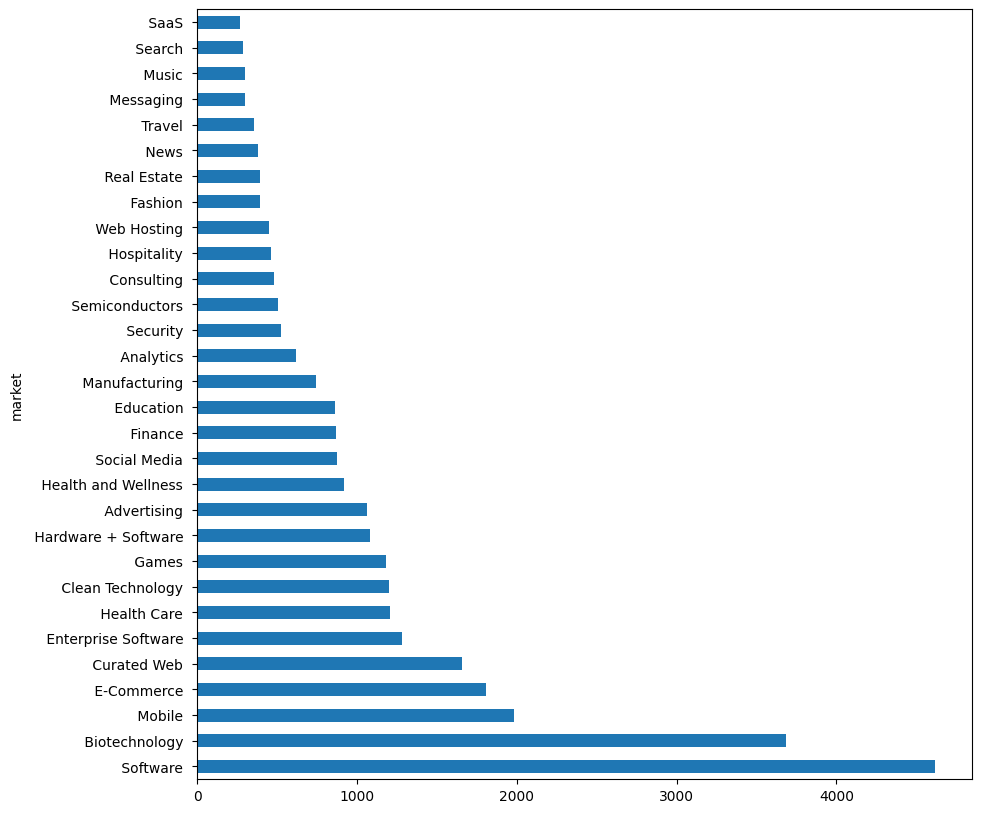

In [23]:
fig, ax = plt.subplots(figsize = (10,10))
data['market'].value_counts()[:30].plot(kind='barh')

In [24]:
# same deal with region
print("Number of unique regions: ", len(set(data['region'])))
print("Regions with more than 200 companies: ",      
      str(sum(data['region'].value_counts() >= 200)))

Number of unique regions:  1090
Regions with more than 200 companies:  44


<Axes: ylabel='region'>

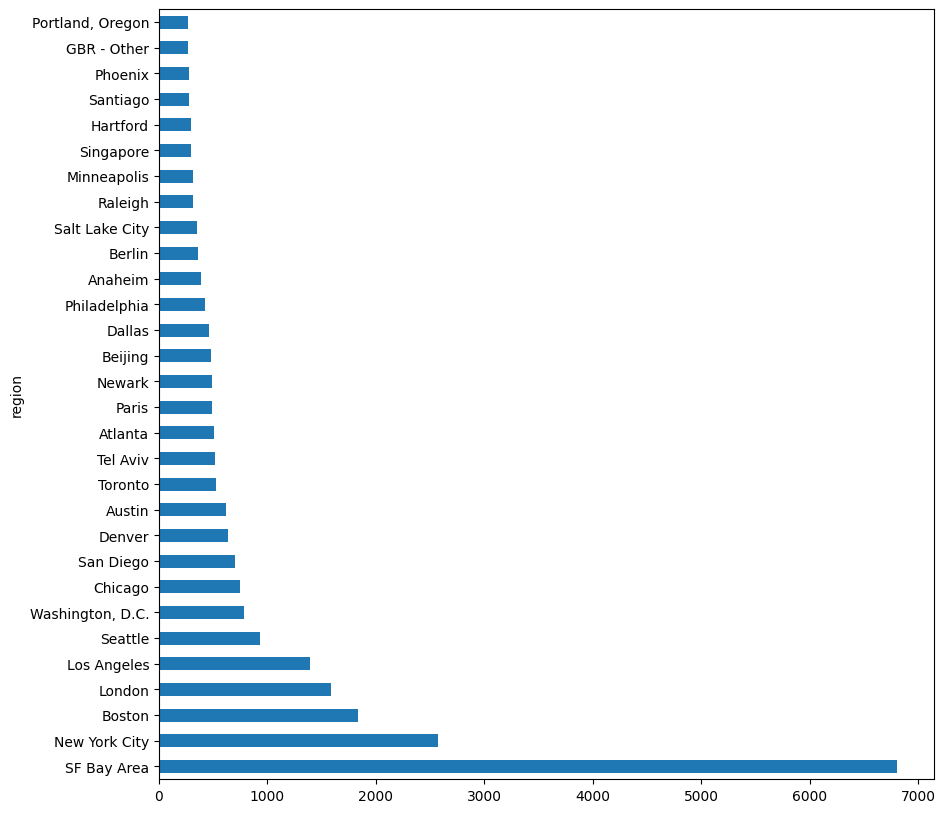

In [25]:
fig, ax = plt.subplots(figsize = (10,10))
data['region'].value_counts()[:30].plot(kind='barh')

array([[<Axes: title={'center': 'equity_crowdfunding'}>]], dtype=object)

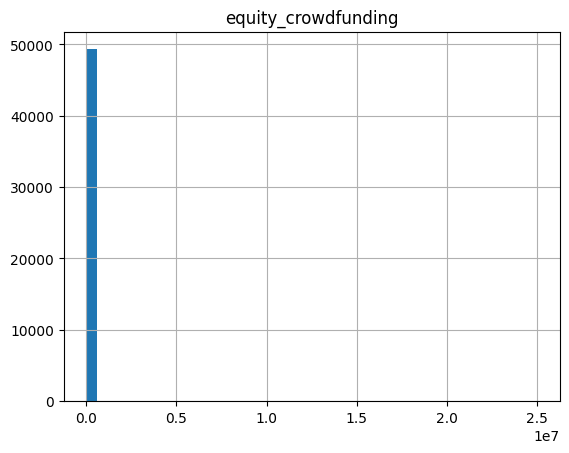

In [26]:
data.hist('equity_crowdfunding', bins=40) 
# there are some very skewed columns in the funding area

### Preprocessing & Feature Engineering

In [27]:
data.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_year', 'first_funding_at', 'last_funding_at',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

#### Missing Values

* I am removing rows with missing status or company name. 
* I am also dropping rows with a missing founded_year because this feature has high importance in many of the models & thus would prefer not to impute at risk of skewing the model. I tried both dropping and keeping  the missing founded_years (imputed). The proportion of companies in each status category & model results are fairly similar with & without imputing the median of year so I am comfortable dropping these rows.

In [28]:
data = data.dropna(subset=['status', 'name', 'founded_year'])
data.isnull().sum()

name                        0
market                   1801
funding_total_usd           0
status                      0
country_code             2936
state_code              13332
region                   2936
city                     3357
funding_rounds              0
founded_at                  0
founded_month               0
founded_year                0
first_funding_at            0
last_funding_at             0
seed                        0
venture                     0
equity_crowdfunding         0
undisclosed                 0
convertible_note            0
debt_financing              0
angel                       0
grant                       0
private_equity              0
product_crowdfunding        0
round_A                     0
round_B                     0
round_C                     0
round_D                     0
round_E                     0
round_F                     0
round_G                     0
round_H                     0
dtype: int64

In [29]:
len(data)

37563

In [30]:
# filling categoricals
data = data.fillna(value={'market': 'other', 'country_code': 'other', 
                          'region': 'other', 'city': 'other', 
                          'state_code': 'other'})

10th percentile of founded_year:  2000.0
Num Rows before 2000:  3518


34045

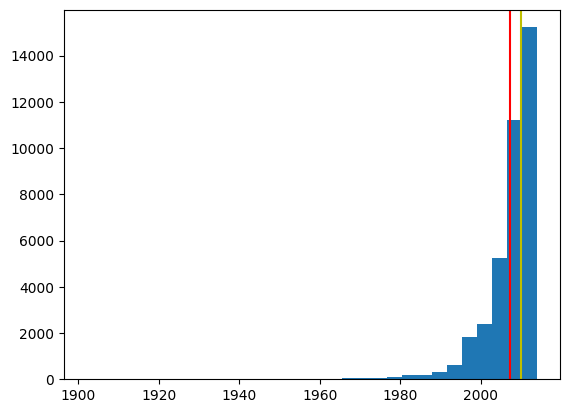

In [31]:
# distribution of non NA years 
plt.hist(data['founded_year'][~data['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data['founded_year']), color='y')

p10 = np.percentile(data['founded_year'][~data['founded_year'].isnull()], 10)
print("10th percentile of founded_year: ", p10)

#10th percentile year is 2000, we will subset for startups founded on or after 2000
print("Num Rows before 2000: ", len(data[data['founded_year'] < 2000]))
data = data[data['founded_year'] >= 2000].reset_index(drop=True)
len(data)

In [32]:
len(df[(df['founded_year'] < 2000) & (df['status'] != 'operating')])

838

Date data - convert to datetime:

In [33]:
data['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                      in data['founded_at'][~data['founded_at'].isnull()]]
data['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['first_funding_at']]
data['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['last_funding_at']]
data['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data['founded_month']]

Fill year & founded_at with simple imputer (only if not removing NaN rows). Since the data is skewed (see plot above), we will use median rather than mean.

In [34]:
# uncomment the below to impute founded_year with mean, only if we are not 
# dropping nans for this feature

#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

#data['founded_year'] = imp_median.fit_transform(data[['founded_year']])
#data['founded_at'] = imp_median.fit_transform(data[['founded_at']])

In [35]:
data['founded_at'] = pd.to_datetime(data['founded_at'])
data['founded_year'] = [day.year for day in data['founded_at']]

In [36]:
data['founded_at'].value_counts()

founded_at
2012-01-01    2100
2011-01-01    2096
2010-01-01    1810
2009-01-01    1561
2013-01-01    1535
              ... 
2011-05-13       1
2005-10-22       1
2010-11-23       1
2010-05-14       1
2012-05-13       1
Name: count, Length: 2935, dtype: int64

In [37]:
data.isna().sum()

name                    0
market                  0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
founded_month           0
founded_year            0
first_funding_at        0
last_funding_at         0
seed                    0
venture                 0
equity_crowdfunding     0
undisclosed             0
convertible_note        0
debt_financing          0
angel                   0
grant                   0
private_equity          0
product_crowdfunding    0
round_A                 0
round_B                 0
round_C                 0
round_D                 0
round_E                 0
round_F                 0
round_G                 0
round_H                 0
dtype: int64

Basic data cleaning:

In [38]:
# getting rid of extra spaces in market, city, state code, region
data['market'] = [x.strip() for x in data['market']]
data['country_code'] = [x.strip() for x in data['country_code']]
data['state_code'] = [x.strip() for x in data['state_code']]
data['region'] = [x.strip() for x in data['region']]
data['city'] = [x.strip() for x in data['city']]

In [39]:
data.dtypes

name                            object
market                          object
funding_total_usd               object
status                          object
country_code                    object
state_code                      object
region                          object
city                            object
funding_rounds                 float64
founded_at              datetime64[ns]
founded_month                    int64
founded_year                     int64
first_funding_at                object
last_funding_at                 object
seed                           float64
venture                        float64
equity_crowdfunding            float64
undisclosed                    float64
convertible_note               float64
debt_financing                 float64
angel                          float64
grant                          float64
private_equity                 float64
product_crowdfunding           float64
round_A                        float64
round_B                  

In [40]:
# need to convert this data type to integer
data['funding_total_usd'].value_counts()

funding_total_usd
0.0           5632
1000000.0      627
100000.0       582
500000.0       573
40000.0        466
              ... 
2115000.0        1
243540.0         1
696081.0         1
19184620.0       1
97398.0          1
Name: count, Length: 10560, dtype: int64

In [41]:
display(data.iloc[0])

name                               #waywire
market                                 News
funding_total_usd                 1750000.0
status                             acquired
country_code                            USA
state_code                               NY
region                        New York City
city                               New York
funding_rounds                          1.0
founded_at              2012-06-01 00:00:00
founded_month                             6
founded_year                           2012
first_funding_at                 2012-06-30
last_funding_at                  2012-06-30
seed                              1750000.0
venture                                 0.0
equity_crowdfunding                     0.0
undisclosed                             0.0
convertible_note                        0.0
debt_financing                          0.0
angel                                   0.0
grant                                   0.0
private_equity                  

In [42]:
# data['funding_total_usd'] = [float(num.replace(" ", "0").replace(",", "0").\
#                                    replace("-", "0")) 
#                              for num in data['funding_total_usd']]
#data['funding_total_usd'].dtypes

#### Feature Engineering

In [43]:
# creating column that labels country as domestic or international
data['international'] = [0 if country=='USA' else 1 for country in data['country_code']]

In [44]:
# creating temporary columns to aid in calculation of time to first funding

data['founded_at_temp'] = [day.date() for day in data['founded_at']]
data['founded_at_temp'] = pd.to_datetime(data['founded_at_temp'], 
                                         format = '%Y-%m-%d')

data['first_funding_at_temp'] = pd.to_datetime(data['first_funding_at'], 
                                               format = '%Y-%m-%d', 
                                               errors='coerce')
data['last_funding_at_temp'] = pd.to_datetime(data['last_funding_at'], 
                                              format = '%Y-%m-%d', 
                                              errors='coerce')

data['time_to_first_funding'] = (data['first_funding_at_temp'] - \
                                 data['founded_at_temp']) / pd.Timedelta(days=365)

data['time_first_to_last_funding'] = (data['last_funding_at_temp'] - \
                                      data['first_funding_at_temp']) / pd.Timedelta(days=365)

In [45]:
# checking for nulls
print(data['first_funding_at'][data['time_to_first_funding'].isnull()])
print(data['last_funding_at'][data['time_first_to_last_funding'].isnull()])

1030     0020-06-14
4514     0019-11-20
9863     0201-01-01
20287    0007-05-13
21784    0001-05-14
Name: first_funding_at, dtype: object
1030     2013-06-01
4514     2013-04-01
9863     0201-01-01
20287    2014-09-25
21784    0001-05-14
Name: last_funding_at, dtype: object


In [46]:
# dropping these
data = data.dropna(subset=['time_to_first_funding'])

#### OPTIONAL - Outliers

48269089.89999999
34040
34040


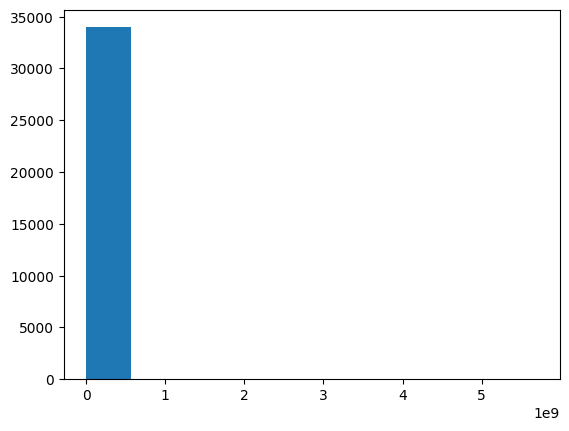

In [47]:
# Funding total USD
print(np.percentile(data['funding_total_usd'], 95))

plt.hist(data['funding_total_usd'][data['funding_total_usd'] < 408206869399.0])
print(len(data[data['funding_total_usd'] < 408206869399.0]))
print(len(data))

32301
32301
34040


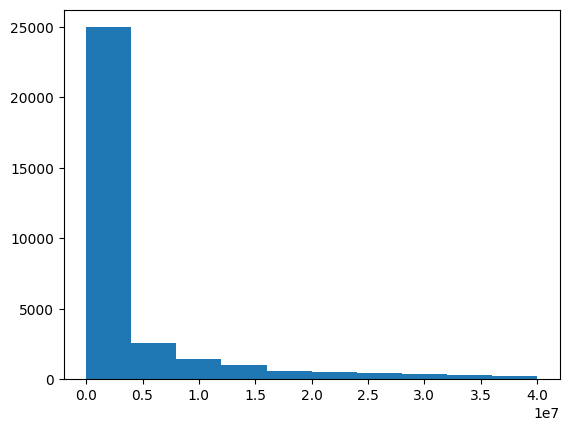

In [48]:
np.percentile(data['venture'], 95)

plt.hist(data['venture'][data['venture'] < 40000000.0])
print(len(data[data['venture'] < 40000000.0]))
print(len(data[(data['venture'] < 40000000.0) & 
               (data['funding_total_usd'] < 408206869399.0)]))
print(len(data))

In [49]:
### THIS DOESN'T HELP THE MODELS, SO I COMMENTED THIS OUT

In [50]:
# uncomment to remove outliers

#data = data[(data['venture'] < 40000000.0) & 
#            (data['funding_total_usd'] < 408206869399.0)].reset_index(drop=True)
#len(data)

#### Correlations

Based on the below, the strongest correlations occur between debt_financing and funding_total_usd, round_H and round_G, followed by venture and all of the rounds of funding

In [51]:
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data['status'])), 
                          data.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

ValueError: could not convert string to float: '#waywire'

In [50]:
#data_corr=data.drop(columns=['status'], axis=1).corr()
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(round_H, round_G)",0.859849
"(funding_rounds, time_first_to_last_funding)",0.793787


In [51]:
# dropping temp columns 
data = data.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                          'first_funding_at_temp', 'last_funding_at_temp', 
                          'founded_at_temp'], axis=1).reset_index(drop=True)

# creating csv file to work from
data.to_csv('data/final_working_data.csv')

In [52]:
# dropping columns with correlation coefficient greater than 0.7
data_uncorr = data.drop(columns=['round_H', 'time_first_to_last_funding'], 
                        axis=1).reset_index(drop=True)

#renaming full dataset
data_full = data

#### OPTIONAL - Binary Representation of Funding Rounds

In [53]:
# data['had_round_A'] = [0 if x==0 else 1 for x in data['round_A']]
# data['had_round_B'] = [0 if x==0 else 1 for x in data['round_B']]
# data['had_round_C'] = [0 if x==0 else 1 for x in data['round_C']]
# data['had_round_D'] = [0 if x==0 else 1 for x in data['round_D']]
# data['had_round_E'] = [0 if x==0 else 1 for x in data['round_E']]
# data['had_round_F'] = [0 if x==0 else 1 for x in data['round_F']]
# data['had_round_G'] = [0 if x==0 else 1 for x in data['round_G']]
# data['had_venture'] = [0 if x==0 else 1 for x in data['venture']]
# data['had_seed'] = [0 if x==0 else 1 for x in data['seed']]
# data['had_eq_crowdfunding'] = [0 if x==0 else 1 for x in data['equity_crowdfunding']]
# data['had_pd_crowdfunding'] = [0 if x==0 else 1 for x in data['product_crowdfunding']]
# data['had_angel'] = [0 if x==0 else 1 for x in data['angel']]
# data['had_grant'] = [0 if x==0 else 1 for x in data['grant']]
# data['had_pe'] = [0 if x==0 else 1 for x in data['private_equity']]
# data['had_convert'] = [0 if x==0 else 1 for x in data['convertible_note']]

## Functions

#### train_test_preprocess

In [54]:
''' 
Function to perform train_test_split and necessary preprocessing / scaling
'''

def train_test_preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]
    
    # Categorizing features in preparation for scaling / encoding
    X_train_cat_eng = X_train.select_dtypes(include=['int64']).reset_index(drop=True)
    X_test_cat_eng = X_test.select_dtypes(include=['int64']).reset_index(drop=True)

    X_train_cont = X_train.select_dtypes(exclude=['object','int64']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object','int64']).reset_index(drop=True)

    cat_columns = ['market', 'region']
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Min Max Scaler:
    scaler = MinMaxScaler() # instantiate MinMaxScaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled, X_test_cat_eng], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont, X_test_cat_eng], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

#### print_scores

In [55]:
''' 
Function to print relevant scoring metrics
'''

def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('PR AUC: ', average_precision_score(y_test, y_hat_test))
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

#### return_scores

In [56]:
''' 
Function that stores relevant scoring metrics
'''

def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    r_train = recall_score(y_train, y_hat_train)
    r_test = recall_score(y_test, y_hat_test)
         
    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

#### train_test_check

In [57]:
''' 
Function that checks new train & test splits for proper shape
'''

def train_test_check(X_train_processed, X_train_scaled, X_test_processed, 
                     X_test_scaled, y_train, y_test):
    
    assert X_train_processed.shape[0] == y_train.shape[0]
    assert X_train_scaled.shape[0] == y_train.shape[0]
    
    assert X_test_processed.shape[0] == y_test.shape[0]
    assert X_test_scaled.shape[0] == y_test.shape[0]

    print("There are {} features in train set".format(len(X_train_processed.columns)))
    print("There are {} features in test set".format(len(X_test_processed.columns)))
    print('\n')

    print("There are {} features in train set (scaled)".format(len(X_train_scaled.columns)))
    print("There are {} features in test set (scaled)".format(len(X_test_scaled.columns)))
    print('\n')
    
    print(f"y_train is a Series with {y_train.shape[0]} values")
    print('\n')
    print("target breakdown: ", y_train.value_counts(normalize=True))

    display(X_train_processed.head())
    display(X_train_scaled.head())

#### correlation_check

In [58]:
''' 
Function that checks for excessive correlations across features
'''
def correlation_check(X_train_processed):
    
    df_corr=X_train_processed.corr()

    df = df_corr.abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # cc for correlation coefficient
    df.columns = ['cc']
    df.drop_duplicates(inplace=True)

    display(df[(df.cc>.5) & (df.cc<1)])

# Modeling

For modeling/classification purposes, we will focus on the subset of the data that includes closed and acquired companies, excluding companies that are currently operating.

In [59]:
data_ac = df[df['status'] != 'operating']

## EDA / Preprocessing

In [60]:
# checking for nulls
data_ac.isnull().sum()

name                       2
market                   611
funding_total_usd          1
status                  1315
country_code             835
state_code              2582
region                   835
city                     951
funding_rounds             1
founded_at              1720
founded_month           1725
founded_year            1725
first_funding_at           1
last_funding_at            1
seed                       1
venture                    1
equity_crowdfunding        1
undisclosed                1
convertible_note           1
debt_financing             1
angel                      1
grant                      1
private_equity             1
product_crowdfunding       1
round_A                    1
round_B                    1
round_C                    1
round_D                    1
round_E                    1
round_F                    1
round_G                    1
round_H                    1
dtype: int64

In [61]:
len(data_ac)

7610

In [62]:
data_ac = data_ac.dropna(subset=['status', 'name'])
len(data_ac)

6294

In [63]:
data_ac.dtypes

name                     object
market                   object
funding_total_usd        object
status                   object
country_code             object
state_code               object
region                   object
city                     object
funding_rounds          float64
founded_at               object
founded_month            object
founded_year            float64
first_funding_at         object
last_funding_at          object
seed                    float64
venture                 float64
equity_crowdfunding     float64
undisclosed             float64
convertible_note        float64
debt_financing          float64
angel                   float64
grant                   float64
private_equity          float64
product_crowdfunding    float64
round_A                 float64
round_B                 float64
round_C                 float64
round_D                 float64
round_E                 float64
round_F                 float64
round_G                 float64
round_H 

In [64]:
# converting to float
data_ac['funding_total_usd'] = [float(num) for num in data_ac['funding_total_usd']]

In [65]:
data_ac['status'].value_counts(normalize=True)

acquired    0.58659
closed      0.41341
Name: status, dtype: float64

In [66]:
# filling categoricals
data_ac = data_ac.fillna(value={'market': 'other', 'country_code': 'other', 
                                'region': 'other', 'city': 'other', 
                                'state_code': 'other'})

1st percentile of founded_year:  1982.0
Num Rows before 1980:  35


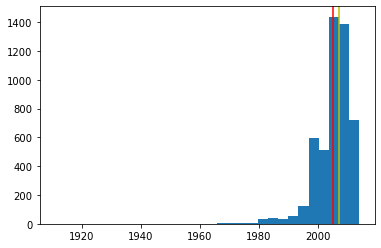

In [67]:
# distribution of non NA years 
plt.hist(data_ac['founded_year'][~data_ac['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data_ac['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data_ac['founded_year']), color='y')

p1 = np.percentile(data_ac['founded_year'][~data_ac['founded_year'].isnull()], 1)
print("1st percentile of founded_year: ", p1)

#1980 looks like a good cutoff point
print("Num Rows before 1980: ", len(data_ac[data_ac['founded_year'] < 1980]))
data_ac = data_ac[data_ac['founded_year'] >= 1980].reset_index(drop=True)

In [68]:
data_ac['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                         in data_ac['founded_at'][~data_ac['founded_at'].isnull()]]
data_ac['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                               in data_ac['first_funding_at']]
data_ac['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                              in data_ac['last_funding_at']]
data_ac['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data_ac['founded_month']]

In [69]:
# imputing median for day, then pulling founded year and month from that
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

data_ac['founded_at'] = imp_median.fit_transform(data_ac[['founded_at']])

data_ac['founded_at'] = pd.to_datetime(data_ac['founded_at'])
data_ac['founded_year'] = [day.year for day in data_ac['founded_at']]
data_ac['founded_month'] = [day.month for day in data_ac['founded_at']]

In [70]:
# creating column that labels country as domestic or international
data_ac['international'] = [0 if country=='USA' else 1 for country in data_ac['country_code']]

In [71]:
# creating temporary columns to aid in calcuation of time to first funding

data_ac['founded_at_temp'] = [day.date() for day in data_ac['founded_at']]
data_ac['founded_at_temp'] = pd.to_datetime(data_ac['founded_at_temp'], 
                                            format = '%Y-%m-%d')

data_ac['first_funding_at_temp'] = pd.to_datetime(data_ac['first_funding_at'], 
                                                  format = '%Y-%m-%d', 
                                                  errors='coerce')
data_ac['last_funding_at_temp'] = pd.to_datetime(data_ac['last_funding_at'], 
                                                 format = '%Y-%m-%d', 
                                                 errors='coerce')

data_ac['time_to_first_funding'] = (data_ac['first_funding_at_temp'] - \
                                    data_ac['founded_at_temp']) / pd.Timedelta(days=365)

data_ac['time_first_to_last_funding'] = (data_ac['last_funding_at_temp'] - \
                                         data_ac['first_funding_at_temp']) / pd.Timedelta(days=365)

In [72]:
# checking for nulls
print(data_ac['first_funding_at'][data_ac['time_to_first_funding'].isnull()])
print(data_ac['last_funding_at'][data_ac['time_first_to_last_funding'].isnull()])

3697    0011-11-14
Name: first_funding_at, dtype: object
3697    2012-07-24
Name: last_funding_at, dtype: object


In [73]:
data_ac = data_ac.dropna(subset=['time_to_first_funding']).reset_index(drop=True)

In [74]:
# getting rid of extra spaces

data_ac['market'] = [x.strip() for x in data_ac['market']]
data_ac['country_code'] = [x.strip() for x in data_ac['country_code']]
data_ac['state_code'] = [x.strip() for x in data_ac['state_code']]
data_ac['region'] = [x.strip() for x in data_ac['region']]
data_ac['city'] = [x.strip() for x in data_ac['city']]

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

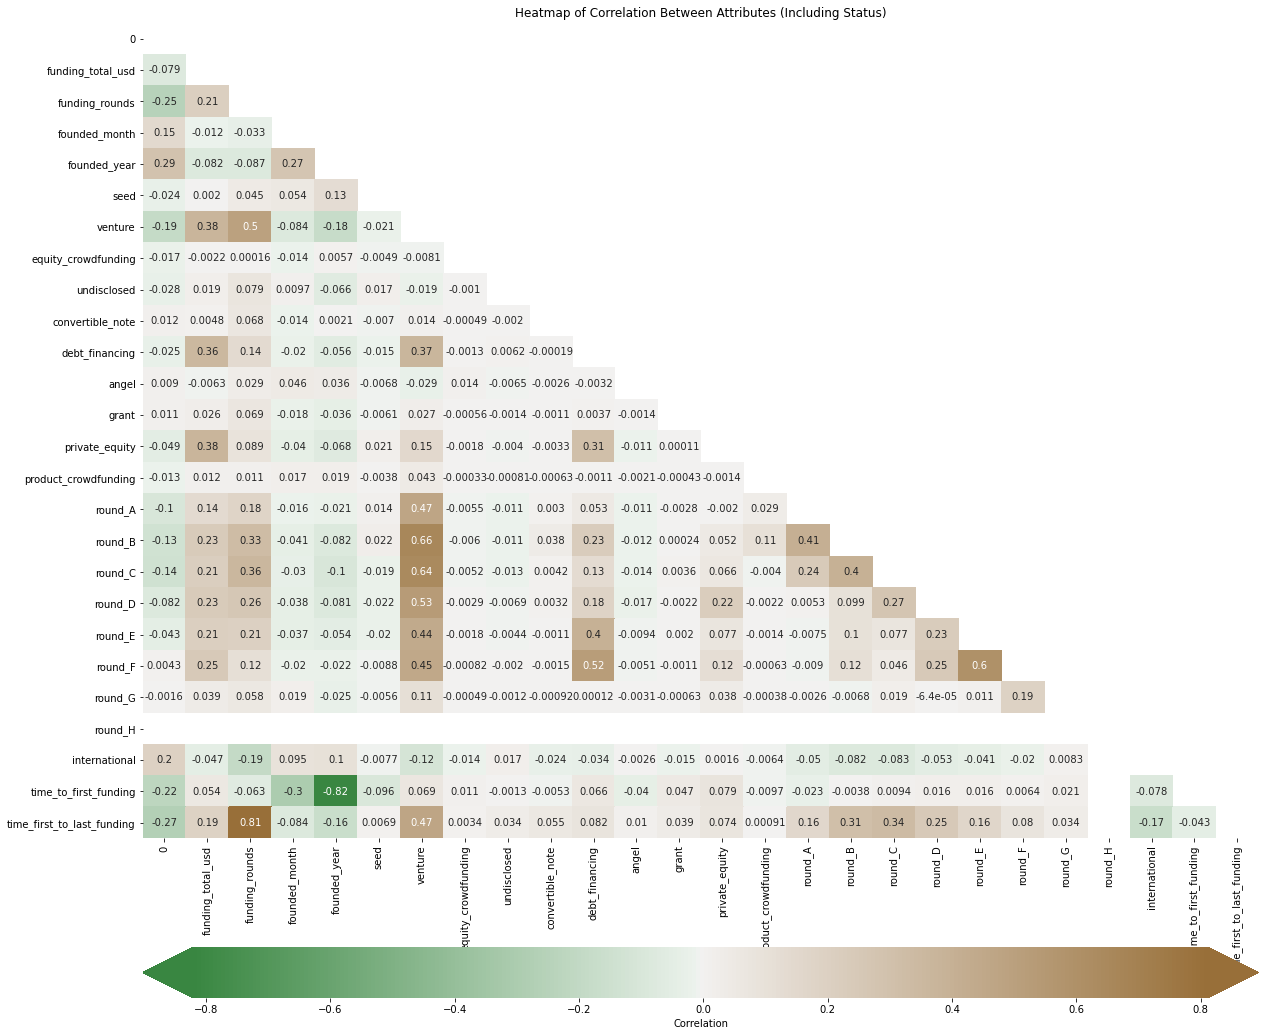

In [75]:
# correlation check
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data_ac['status'])), 
                          data_ac.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [76]:
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(time_to_first_funding, founded_year)",0.819908
"(funding_rounds, time_first_to_last_funding)",0.812019


In [77]:
# reducing number of categories in market & region

print(sum(data_ac['market'].value_counts() >= 15)) # top ~50 markets
data_ac['market'][data_ac['market'].map(data_ac['market'].value_counts()) < 15] = 'other'
print(data_ac['market'].value_counts())

print(sum(data_ac['region'].value_counts() >= 60)) # top 10-15 regions
data_ac['region'][data_ac['region'].map(data_ac['region'].value_counts()) < 60] = 'other'
print(data_ac['region'].value_counts())

48
other                    1162
Software                  569
Curated Web               347
Mobile                    281
Enterprise Software       200
Biotechnology             189
Advertising               173
Games                     172
E-Commerce                164
Social Media              136
Hardware + Software       100
Semiconductors             96
Security                   92
Web Hosting                84
Clean Technology           78
Health Care                75
Finance                    71
Analytics                  59
Messaging                  55
Search                     54
News                       47
Music                      45
Education                  43
Public Relations           42
Video                      41
Travel                     40
Networking                 38
Photography                36
Social Network Media       34
Consulting                 33
Health and Wellness        32
SaaS                       29
Sports                     25
Web Dev

In [78]:
#data_ac['region'].value_counts()[data_ac['region'].value_counts() > 75]

In [79]:
# dropping correlated columns for logistic regression, which can be
# sensitive to correlated features
data_final = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                   'first_funding_at_temp', 'last_funding_at_temp', 
                                   'founded_at_temp', 'round_H', 'founded_year',  
                                   'time_first_to_last_funding'], 
                       axis=1)
# all inclusive
data_final2 = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                    'first_funding_at_temp', 'last_funding_at_temp', 
                                    'founded_at_temp', 'round_H'], 
                       axis=1)

In [80]:
data_final.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding'],
      dtype='object')

In [81]:
data_final2.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding', 'time_first_to_last_funding'],
      dtype='object')

## X/Y Split

In [82]:
X_ac = data_final2.drop(columns=['status', 'name', 'country_code', 
                                 'state_code', 'city'], axis=1)

encoder = LabelEncoder()
y_ac = pd.Series(encoder.fit_transform(data_final2['status'])) 
# acquired is 0, closed is 1

y_ac.value_counts(normalize=True)

0    0.59716
1    0.40284
dtype: float64

For the logistic regression model, we'll get rid of some extre outliers and exclude highly correlated features

87064646.92499983
0
4930


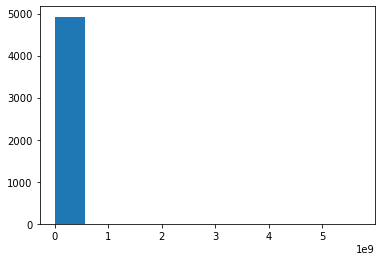

In [83]:
# Funding total USD
print(np.percentile(data_final['funding_total_usd'], 97.5))

plt.hist(data_final['funding_total_usd'][data_final['funding_total_usd'] < 800000000000])
print(len(data_final[data_final['funding_total_usd'] >= 800000000000.0]))
print(len(data_final))

69561028.64999995
119
0
4930


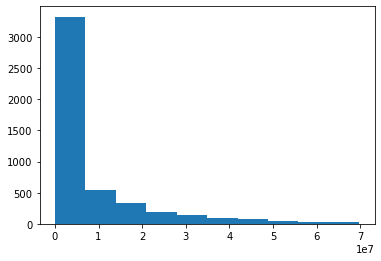

In [84]:
print(np.percentile(data_final['venture'], 97.5))

plt.hist(data_final['venture'][data_final['venture'] < 70000000.0])
print(len(data_final[data_final['venture'] > 70000000.0]))
print(len(data_final[(data_final['venture'] > 70000000.0) & 
               (data_final['funding_total_usd'] > 800000000000.0)]))
print(len(data_final))

In [85]:
data_lr = data_final[(data_final['venture'] < 70000000.0) & 
                     (data_final['funding_total_usd'] < 800000000000.0)].reset_index(drop=True)

In [86]:
correlation_check(data_lr)

,cc
pairs,
"(round_B, venture)",0.605892
"(venture, round_C)",0.594695
"(venture, funding_rounds)",0.540045


In [87]:
X_ac_lr = data_lr.drop(columns=['status', 'name', 'country_code', 
                                'state_code', 'city', 'funding_total_usd'], 
                       axis=1)

encoder = LabelEncoder()
y_ac_lr = pd.Series(encoder.fit_transform(data_lr['status'])) 
# acquired is 0, closed is 1

y_ac_lr.value_counts(normalize=True)

0    0.59089
1    0.40911
dtype: float64

## Baseline Model

In [88]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac_lr, y_ac_lr)

In [89]:
train_test_check(X_train_processed, X_train_scaled, X_test_processed, 
                 X_test_scaled, y_train, y_test)

There are 82 features in train set
There are 82 features in test set


There are 82 features in train set (scaled)
There are 82 features in test set (scaled)


y_train is a Series with 3606 values


target breakdown:  0    0.594565
1    0.405435
dtype: float64


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,international
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25000000.0,0.0,0.0,0.0,0.0,3.882192,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12000000.0,0.0,0.0,0.0,0.0,0.0,1.690411,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.358904,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15928800.0,0.0,6960000.0,9520000.0,0.0,0.0,0.0,0.928767,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583562,1,0


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,international
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.403226,0.000000,0.0,0.0,0.0,0.626463,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.190476,0.000000,0.000000,0.0,0.0,0.0,0.600020,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.692537,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.249944,0.000000,0.112258,0.158667,0.0,0.0,0.0,0.590831,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.586666,1,0


In [90]:
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [91]:
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6231190150478796
Testing Recall:  0.5564356435643565


Training F1:  0.6537495514890563
Testing F1:  0.5985090521831736


ROC AUC:  0.6684617242212028
PR AUC:  0.5466289207725683


Training Accuracy:  0.7323904603438713
Testing Accuracy:  0.6863560732113144


### Baseline Analysis

* 60% recall is not a great start, but would like to see if hypertuning can improve this
* 70% accuracy also leaves something to be desired

### Grid Search on Baseline**

In [92]:
param_grid = {'penalty':['l2', None],
              'solver':['lbfgs', 'sag'],
              'C': [1.0, 1e12], 
              'class_weight': [None, 'balanced']
             }

In [93]:
grid_logreg = GridSearchCV(baseline_model, param_grid, cv = 5, 
                           scoring='recall') # macro or weighted
grid_logreg.fit(X_train_scaled, y_train)
grid_logreg.best_params_

{'C': 1000000000000.0,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'sag'}

In [94]:
y_preds_grid_lr_train = grid_logreg.predict(X_train_scaled)
y_preds_grid_lr = grid_logreg.predict(X_test_scaled)

print_scores(y_train, y_preds_grid_lr_train, y_test, y_preds_grid_lr)

Training Recall:  0.7701778385772914
Testing Recall:  0.689108910891089


Training F1:  0.6891064871481029
Testing F1:  0.6492537313432836


ROC AUC:  0.6874525903092461
PR AUC:  0.5535607922570246


Training Accuracy:  0.7182473655019412
Testing Accuracy:  0.6871880199667221


In [95]:
## Top coefficients
lr = LogisticRegression(random_state=42, class_weight='balanced', 
                        solver='lbfgs', C=1e12, penalty='l2')
lr.fit(X_train_scaled, y_train)

coef_df = pd.DataFrame(lr.coef_, columns=X_train_scaled.columns).transpose()
coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
time_to_first_funding,-13.671024,13.671024
private_equity,-3.990688,3.990688
funding_rounds,-3.559181,3.559181
seed,-3.494325,3.494325
convertible_note,2.275083,2.275083
round_A,-2.210779,2.210779
grant,2.097817,2.097817
venture,-1.935693,1.935693
market_Clean Technology,1.713918,1.713918
debt_financing,-1.557564,1.557564


In [96]:
X_train_scaled['private_equity'].value_counts() 
# vast majority of observations are 0, so coefficient probably isn't
# as important as its ranking implies

0.000000    3544
0.200000       3
0.004000       2
0.150000       2
0.220000       1
0.139800       1
0.012000       1
0.036728       1
0.000758       1
1.000000       1
0.290000       1
0.250000       1
0.147080       1
0.023200       1
0.140000       1
0.886000       1
0.000026       1
0.001666       1
0.504000       1
0.028000       1
0.450000       1
0.256000       1
0.037916       1
0.121000       1
0.192500       1
0.080000       1
0.006652       1
0.061217       1
0.255000       1
0.013196       1
0.166000       1
0.093727       1
0.400000       1
0.300000       1
0.317400       1
0.024000       1
0.003340       1
0.340000       1
0.008000       1
0.166600       1
0.235000       1
0.027253       1
0.026000       1
0.019000       1
0.144000       1
0.079444       1
0.120000       1
0.099500       1
0.636000       1
0.000153       1
0.012212       1
0.108642       1
0.020000       1
0.011137       1
0.566000       1
0.009000       1
0.010000       1
0.737000       1
0.160000      

## Custom Pipeline

In [97]:
scores = pd.DataFrame(columns = ['recall_train', 'recall_test', 'f1_train', 
                                 'f1_test', 'accuracy_train', 'accuracy_test', 
                                 'roc_auc', 'pr_auc', 'params'])

In [98]:
# creates a data frame with various scores for each model
def customPipe(model, model_name, X, y):
    X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
    y_train, y_test = train_test_preprocess(X, y)
    
    if ('lr' in model_name) | ('knn' in model_name):
        model.fit(X_train_scaled, y_train)
        y_hat_train = model.predict(X_train_scaled)
        y_hat_test = model.predict(X_test_scaled)

    else:
        model.fit(X_train_processed, y_train)
        y_hat_train = model.predict(X_train_processed)
        y_hat_test = model.predict(X_test_processed)
    
    r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = \
    return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    score_list = []
    score_list.extend((r_train, r_test, f1_train, f1_test, 
                       ac_train, ac_test, roc_auc, pr_auc, str(model)))
    
    scores.loc[model_name] = score_list
    return scores

In [99]:
# model inputs
lr = LogisticRegression(random_state=42, class_weight='balanced', 
                        solver='lbfgs', C=1e12, penalty='l2')
rf = RandomForestClassifier(random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
ext = ExtraTreesClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
knn = KNeighborsClassifier()

In [100]:
# running the function
customPipe(lr, 'lr', X_ac_lr, y_ac_lr)
customPipe(rf, 'rf', X_ac, y_ac)
customPipe(dtc, 'dtc', X_ac, y_ac)
customPipe(ext, 'ext', X_ac, y_ac)
customPipe(xgb, 'xgb', X_ac, y_ac)
customPipe(knn, 'knn', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.762654,0.693069,0.685310,0.652377,0.716029,0.689684,0.690150,0.556019,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.641921,1.000000,0.733982,0.710802,0.581653,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.587174,1.000000,0.629431,1.000000,0.720195,0.698901,0.565318,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()


Looking at recall and accuracy, the Random Forest and XGBoost models seem to yield the best scores. Will hyper tune each of these models.

In [101]:
# storing dataframe for easy access
scores_base = scores # models pre hyper parameter tuning

## Other Models - Hypertuning

In [102]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac, y_ac)

In [103]:
train_test_check(X_train_processed, X_train_scaled, X_test_processed, 
                 X_test_scaled, y_train, y_test)

There are 85 features in train set
There are 85 features in test set


There are 85 features in train set (scaled)
There are 85 features in test set (scaled)


y_train is a Series with 3697 values


target breakdown:  0    0.597782
1    0.402218
dtype: float64


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,time_first_to_last_funding,founded_month,founded_year,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.298630,0.000000,4,2009,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.498630,0.873973,1,2012,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.961644,0.000000,1,2007,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.942466,0.000000,1,2010,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15500000.0,3340000.0,0.0,0.0,0.0,3.498630,7.071233,1,2003,0


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,time_first_to_last_funding,founded_month,founded_year,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.222040,0.000000,4,2009,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.239689,0.055257,1,2012,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.294214,0.000000,1,2007,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.293789,0.000000,1,2010,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.134783,0.017041,0.0,0.0,0.0,0.306101,0.447081,1,2003,0


### Random Forest

In [104]:
rf = RandomForestClassifier(random_state=42)

# Initial search
rf_param_grid = {
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[8,12,20],
    'min_samples_leaf': [5,10],
    'class_weight': [None, 'balanced']
}

## results from initial search
# {'class_weight': 'balanced',
#  'criterion': 'gini',
#  'max_depth': 20,
#  'min_samples_leaf': 5}

# Fine tuning
rf_param_grid2 = {
    'criterion':['gini'], 
    'max_depth':[12,20,25],
    'min_samples_leaf': [10,15,20],
    'class_weight': ['balanced'],
    'n_estimators': [100, 200]
}

grid_rfc = GridSearchCV(rf, rf_param_grid2, cv = 5, scoring='recall') 
grid_rfc.fit(X_train_processed, y_train)

grid_rfc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 25,
 'min_samples_leaf': 10,
 'n_estimators': 200}

In [105]:
y_preds_grid_rfc_train = grid_rfc.predict(X_train_processed)
y_preds_grid_rfc = grid_rfc.predict(X_test_processed)

print_scores(y_train, y_preds_grid_rfc_train, y_test, y_preds_grid_rfc)

Training Recall:  0.738399462004035
Testing Recall:  0.7094188376753507


Training F1:  0.7254707631318137
Testing F1:  0.696165191740413


ROC AUC:  0.7429927975842694
PR AUC:  0.6024145414020053


Training Accuracy:  0.7752231539085745
Testing Accuracy:  0.7493917274939172


In [106]:
rf_best = RandomForestClassifier(random_state = 42, class_weight='balanced', 
                                 criterion='gini', max_depth=25, 
                                 min_samples_leaf=10, n_estimators=200) 
customPipe(rf_best, 'rf_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.762654,0.693069,0.685310,0.652377,0.716029,0.689684,0.690150,0.556019,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.641921,1.000000,0.733982,0.710802,0.581653,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.587174,1.000000,0.629431,1.000000,0.720195,0.698901,0.565318,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.738399,0.709419,0.725471,0.696165,0.775223,0.749392,0.742993,0.602415,RandomForestClassifier(class_weight='balanced'...


#### Feature Importance

In [107]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, rf_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_rf = pd.DataFrame(feats.items())

feats_rf.columns = ['col', 'feat_importance']
feats_rf = feats_rf.sort_values(by=['feat_importance'], ascending=False)
feats_rf_20 = feats_rf[:20]
feats_rf_30 = feats_rf[:30]

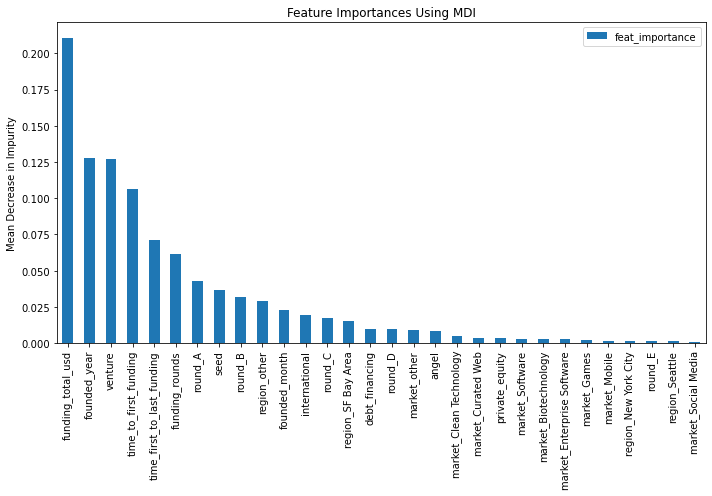

In [108]:
fig, ax = plt.subplots(figsize = (10,7))
feats_rf_30.plot.bar(ax=ax)  
ax.set_title("Feature Importances Using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xticklabels(feats_rf_30['col'])
fig.tight_layout()

In [109]:
list(feats_rf['col'][:10])

['funding_total_usd',
 'founded_year',
 'venture',
 'time_to_first_funding',
 'time_first_to_last_funding',
 'funding_rounds',
 'round_A',
 'seed',
 'round_B',
 'region_other']

### XG Boost*

In [110]:
# 45+ runtime
xgb = XGBClassifier(random_state=42)

# initial grid search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4,6,8],
    'min_child_weight': [3,5,7],
    'subsample': [0.5, 0.7],
    'scale_pos_weight':[1.5, 2]
}

## result from initial grid search:
# {'learning_rate': 0.1,
#  'max_depth': 4,
#  'min_child_weight': 7,
#  'scale_pos_weight': 2,
#  'subsample': 0.7}

# fine tuning
xgb_param_grid2 = {
    'learning_rate': [0.1,0.2],
    'max_depth': [1,2,4],
    'min_child_weight': [3,7,10],
    'subsample': [0.7],
    'scale_pos_weight':[2]
}

grid_xgb = GridSearchCV(xgb, xgb_param_grid2, cv = 5, scoring='recall') 
grid_xgb.fit(X_train_processed, y_train)

grid_xgb.best_params_

{'learning_rate': 0.2,
 'max_depth': 1,
 'min_child_weight': 7,
 'scale_pos_weight': 2,
 'subsample': 0.7}

In [111]:
xgb_best = XGBClassifier(random_state=42, max_depth=1, min_child_weight=7, 
                         subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(xgb_best, 'xgb_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.762654,0.693069,0.685310,0.652377,0.716029,0.689684,0.690150,0.556019,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.641921,1.000000,0.733982,0.710802,0.581653,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.587174,1.000000,0.629431,1.000000,0.720195,0.698901,0.565318,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.738399,0.709419,0.725471,0.696165,0.775223,0.749392,0.742993,0.602415,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.803631,0.799599,0.706682,0.696943,0.731674,0.718573,0.731543,0.574973,"XGBClassifier(base_score=0.5, booster='gbtree'..."


#### Feature Importance

In [112]:
xgb_best.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=1,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
f = 'gain' # importance type
feat_imp = xgb_best.get_booster().get_score(importance_type= f)
feats_xg = pd.DataFrame(sorted(feat_imp.items(), key=lambda item: item[1], 
                            reverse=True))
feats_xg.columns = ['col', 'feat_importance']
feats_xg[:15]

,col,feat_importance
0,funding_total_usd,120.335433
1,founded_year,45.184254
2,time_first_to_last_funding,41.682578
3,international,39.813609
4,region_other,38.373383
5,time_to_first_funding,24.078237
6,region_SF Bay Area,22.668856
7,funding_rounds,18.984874
8,seed,18.831061
9,round_B,18.659117


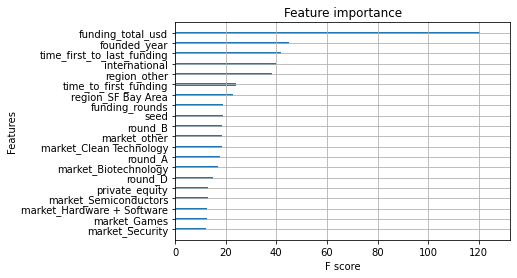

In [114]:
from xgboost import plot_importance
plot_importance(xgb_best, max_num_features=20, importance_type=f, 
                show_values=False)
plt.show()

[Text(0.5, 0, 'Feature Importance Score'),
 Text(0, 0.5, 'Feature'),
 Text(0.5, 1.0, 'XG Boost Feature Importance')]

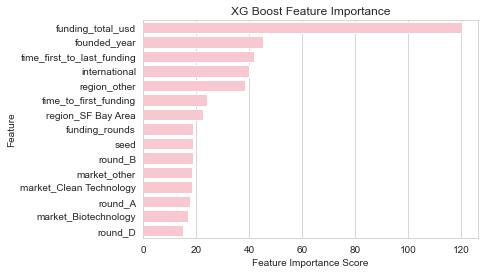

In [115]:
feats_xg[:15]

sns.set_style("whitegrid")
sns.set_palette('Blues')

g = sns.barplot(x='feat_importance', y='col', data=feats_xg[:15], color='pink') 
# g.set_xticklabels(["U.S.", "International"])
g.set(xlabel='Feature Importance Score', 
      ylabel='Feature',
      title="XG Boost Feature Importance")

### ExtraTrees

In [116]:
ext_param_grid = {'criterion':['entropy','gini'],
              'max_depth':[15,20,25],
              'min_samples_leaf': [1,5],
              'class_weight': ['balanced'],
              'max_features': ['auto']
             }

ext = ExtraTreesClassifier(random_state=42)

grid_ext = GridSearchCV(ext, ext_param_grid, cv = 5, scoring='recall') 
grid_ext.fit(X_train_processed, y_train)

grid_ext.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 5}

In [117]:
ext_grid = ExtraTreesClassifier(random_state=42, class_weight='balanced',
                                criterion='gini', max_depth= 15,
                                max_features='auto', min_samples_leaf= 5)
customPipe(ext_grid, 'ext_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.762654,0.693069,0.685310,0.652377,0.716029,0.689684,0.690150,0.556019,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.641921,1.000000,0.733982,0.710802,0.581653,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.587174,1.000000,0.629431,1.000000,0.720195,0.698901,0.565318,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.738399,0.709419,0.725471,0.696165,0.775223,0.749392,0.742993,0.602415,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.803631,0.799599,0.706682,0.696943,0.731674,0.718573,0.731543,0.574973,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.765299,0.711423,0.715049,0.667921,0.754666,0.713706,0.713341,0.564581,"ExtraTreesClassifier(class_weight='balanced', ..."


### Decision Tree***

In [118]:
dtc_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15],
                  'min_samples_leaf': [15,20,25],
                  'class_weight': [None, 'balanced']
             }

dtc = DecisionTreeClassifier(random_state=42)

grid_dtc = GridSearchCV(dtc, dtc_param_grid, cv = 5, scoring='recall') 
grid_dtc.fit(X_train_processed, y_train)

grid_dtc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 15}

In [119]:
dtc_best = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                  criterion='gini', max_depth= 5,
                                  min_samples_leaf= 15)

dtc_best.fit(X_train_processed, y_train)
customPipe(dtc_best, 'dtc_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.762654,0.693069,0.685310,0.652377,0.716029,0.689684,0.690150,0.556019,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.641921,1.000000,0.733982,0.710802,0.581653,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.587174,1.000000,0.629431,1.000000,0.720195,0.698901,0.565318,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.738399,0.709419,0.725471,0.696165,0.775223,0.749392,0.742993,0.602415,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.803631,0.799599,0.706682,0.696943,0.731674,0.718573,0.731543,0.574973,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.765299,0.711423,0.715049,0.667921,0.754666,0.713706,0.713341,0.564581,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.806994,0.787575,0.710900,0.687063,0.736002,0.709651,0.722125,0.565841,DecisionTreeClassifier(class_weight='balanced'...


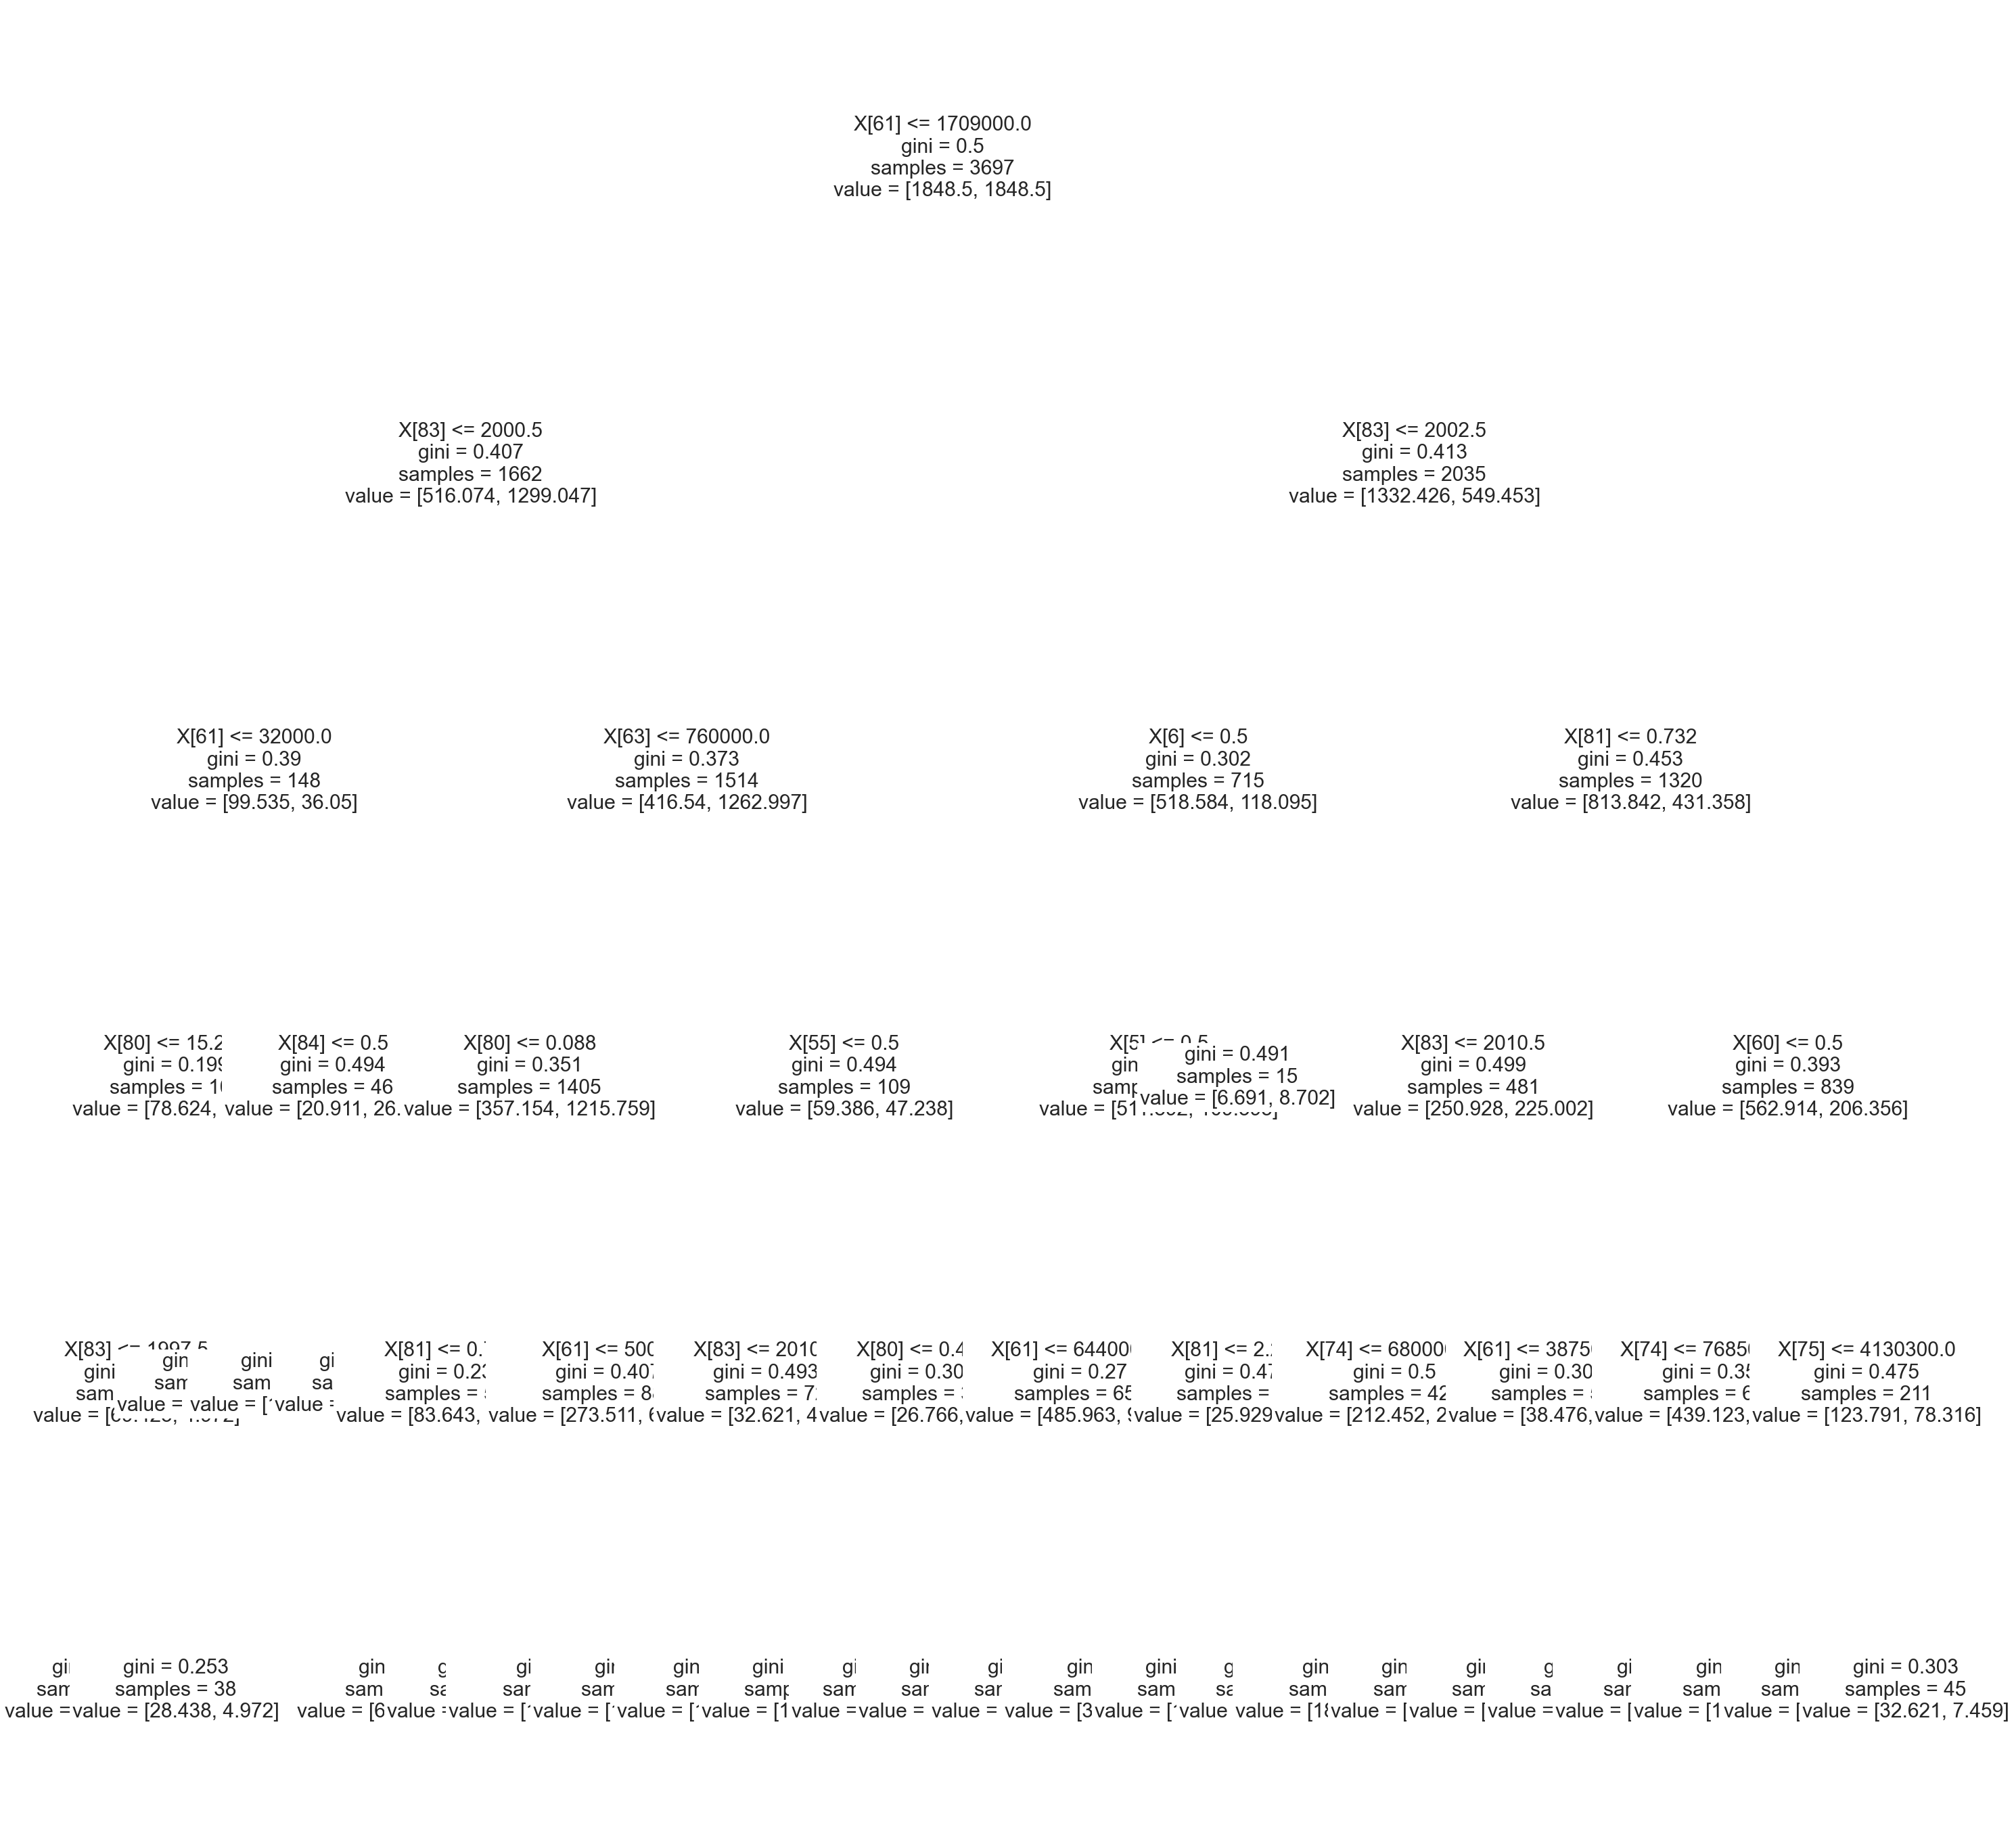

In [120]:
from sklearn.tree import DecisionTreeClassifier, plot_tree 

f,ax = plt.subplots(figsize=(50,50))
plot_tree(dtc_best, ax=ax, fontsize=30);

#### Feature Importance

In [121]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, dtc_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_dtc = pd.DataFrame(feats.items())

feats_dtc.columns = ['col', 'feat_importance']
feats_dtc = feats_dtc.sort_values(by=['feat_importance'], ascending=False)
feats_dtc_30 = feats_dtc[:30]

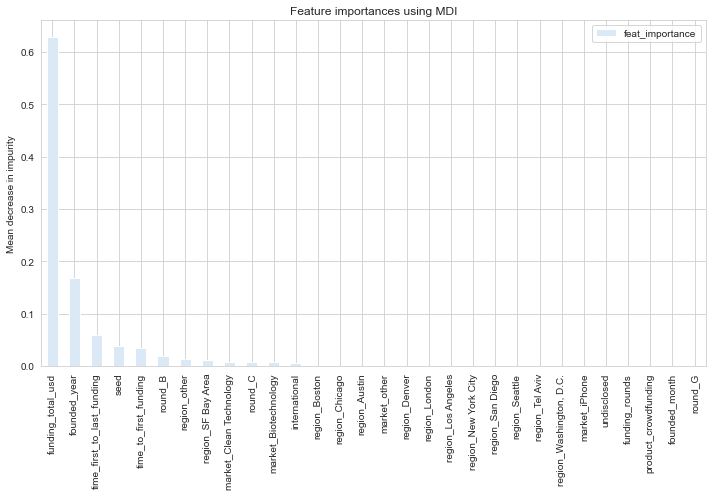

In [122]:
fig, ax = plt.subplots(figsize = (10,7))
feats_dtc_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_dtc_30['col'])
fig.tight_layout()

## Final Model

* XG Boost is the best model, with ~80% recall, 72% accuracy and 73% AUC
* Now that we have narrowed down the best models, we will run them with reduced features & SMOTE to see if that generates any improvement

In [123]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac, y_ac)

### Feature Reduction

In [124]:
# top 20 features
X_train_xg = X_train_processed[list(feats_xg['col'][:20])]
X_train_dtc = X_train_processed[list(feats_dtc['col'][:20])]

X_test_xg = X_test_processed[list(feats_xg['col'][:20])]
X_test_dtc = X_test_processed[list(feats_dtc['col'][:20])]

In [125]:
# XG Boost
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=7, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

final_model.fit(X_train_xg, y_train)

y_hat_train = final_model.predict(X_train_xg)
y_hat_test = final_model.predict(X_test_xg)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8049764626765299
Testing Recall:  0.7875751503006012


Training F1:  0.7105966162065894
Testing F1:  0.6906854130052724


ROC AUC:  0.7262126432701916
PR AUC:  0.570346385974146


Training Accuracy:  0.7362726535028401
Testing Accuracy:  0.7145174371451744


In [126]:
# Decision Trees - 2nd place
final_model = dtc_best
final_model.fit(X_train_dtc, y_train)

y_hat_train = final_model.predict(X_train_dtc)
y_hat_test = final_model.predict(X_test_dtc)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8069939475453934
Testing Recall:  0.7875751503006012


Training F1:  0.7109004739336493
Testing F1:  0.6870629370629371


ROC AUC:  0.7221254498097012
PR AUC:  0.565840551507965


Training Accuracy:  0.7360021639166892
Testing Accuracy:  0.7096512570965126


Feature reduction doesn't improve the models.

### SMOTE

In [127]:
#Using SMOTE to further reduce class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_processed, y_train) 

In [128]:
# addressing class imbalance within the hyperparameters results in higher recall
final_model_smote = XGBClassifier(random_state=42, max_depth=1, min_child_weight=7, 
                                  subsample=0.7, learning_rate=0.2)

final_model_smote.fit(X_train_resampled, y_train_resampled)

y_hat_train = final_model_smote.predict(X_train_resampled)
y_hat_test = final_model_smote.predict(X_test_processed)

print_scores(y_train_resampled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7728506787330317
Testing Recall:  0.7414829659318637


Training F1:  0.768503937007874
Testing F1:  0.7020872865275142


ROC AUC:  0.7447196846008093
PR AUC:  0.5989448483341379


Training Accuracy:  0.7671945701357467
Testing Accuracy:  0.7453365774533658


### Model Selection

In [129]:
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=7, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(final_model, 'final_model', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.762654,0.693069,0.685310,0.652377,0.716029,0.689684,0.690150,0.556019,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.641921,1.000000,0.733982,0.710802,0.581653,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.587174,1.000000,0.629431,1.000000,0.720195,0.698901,0.565318,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.738399,0.709419,0.725471,0.696165,0.775223,0.749392,0.742993,0.602415,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.803631,0.799599,0.706682,0.696943,0.731674,0.718573,0.731543,0.574973,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.765299,0.711423,0.715049,0.667921,0.754666,0.713706,0.713341,0.564581,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.806994,0.787575,0.710900,0.687063,0.736002,0.709651,0.722125,0.565841,DecisionTreeClassifier(class_weight='balanced'...


In [130]:
# storing dataframe for easy access
scores_final = scores
scores_final.to_csv('final_scores.csv')
scores_final.sort_values(by=['recall_test'], ascending=False)[1:]

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
final_model,0.803631,0.799599,0.706682,0.696943,0.731674,0.718573,0.731543,0.574973,"XGBClassifier(base_score=0.5, booster='gbtree'..."
dtc_best,0.806994,0.787575,0.710900,0.687063,0.736002,0.709651,0.722125,0.565841,DecisionTreeClassifier(class_weight='balanced'...
ext_best,0.765299,0.711423,0.715049,0.667921,0.754666,0.713706,0.713341,0.564581,"ExtraTreesClassifier(class_weight='balanced', ..."
rf_best,0.738399,0.709419,0.725471,0.696165,0.775223,0.749392,0.742993,0.602415,RandomForestClassifier(class_weight='balanced'...
lr,0.762654,0.693069,0.685310,0.652377,0.716029,0.689684,0.690150,0.556019,"LogisticRegression(C=1000000000000.0, class_we..."
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
rf,1.000000,0.589178,1.000000,0.641921,1.000000,0.733982,0.710802,0.581653,RandomForestClassifier(random_state=42)
ext,1.000000,0.587174,1.000000,0.629431,1.000000,0.720195,0.698901,0.565318,ExtraTreesClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()


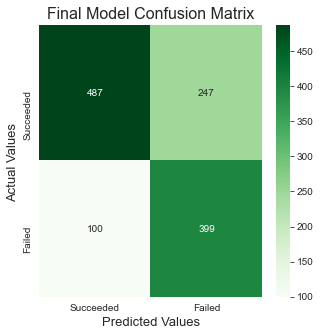

In [131]:
# visualizing predictions

y_hat_test = final_model.predict(X_test_processed)

conf_matrix = confusion_matrix(y_test, y_hat_test)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Succeeded','Failed'])
ax.yaxis.set_ticklabels(['Succeeded','Failed'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [132]:
#### Entering a Fake Example, seeing how it is classified

In [133]:
# explanation - why recall? why not accuracy?
# plot_tree

# Visualizations

Text(0.5, 0.98, 'Model Performance')

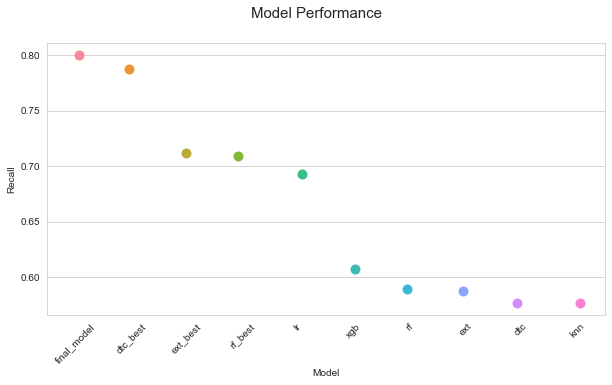

In [134]:
## Model Comparison
scores_viz = scores_final.sort_values(by=['recall_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="recall_test", data=scores_viz, size=10)
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("Recall", fontsize=10)
fig.suptitle("Model Performance", fontsize=15)

In [135]:
## Visualizing Important Features

In [136]:
df = data_final2 #df for viz - uncomment for viz

# adding variables to help with viz
df['int_category'] = ['international' if x==1 else 'U.S.' for x in df['international']]
df['one_funding_round'] = ['one' if x==1 else 'multiple' for x in df['funding_rounds']]

df_box = df[(df['venture'] < 40000000.0)] # getting rid of outliers for boxplot

cmap = sns.diverging_palette(130, 50, as_cmap=True)

<Figure size 360x360 with 0 Axes>

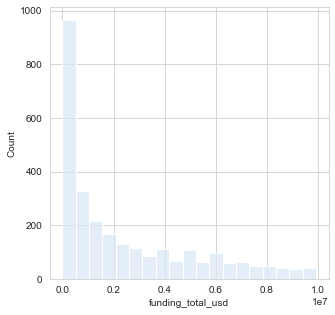

In [137]:
# total funding histograms - all, successes, and failures

fig = plt.figure(figsize=(5, 5)) 
fig, ax = plt.subplots(figsize=(5, 5))

# excluding outliers, companies with 0 funding
df_fund = df[(df['funding_total_usd'] < 10000000) & 
             (df['funding_total_usd'] > 0)]

df_success = df_fund[df_fund['status']=='acquired']
df_failure = df_fund[df_fund['status']=='closed']

#all - right skew
plot = sns.histplot(x='funding_total_usd', data=df_fund, bins='auto')

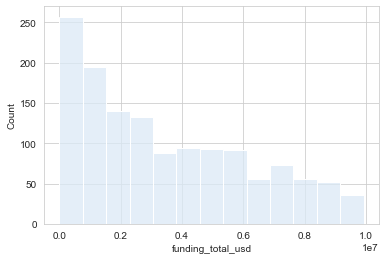

In [138]:
# successes - fairly even distribution
plot = sns.histplot(x='funding_total_usd', data=df_success, bins='auto')

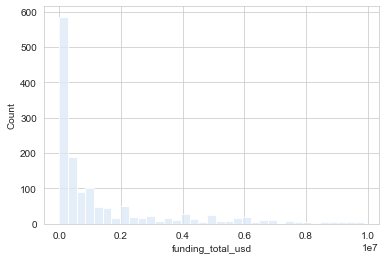

In [139]:
# failures - right skew
plot = sns.histplot(x='funding_total_usd', data=df_failure, bins='auto')

<AxesSubplot:xlabel='venture', ylabel='status'>

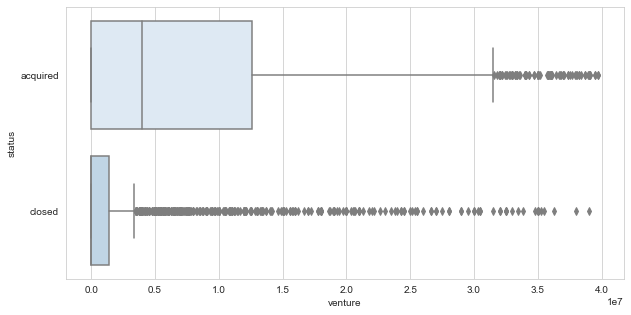

In [140]:
# boxplot of VC funding, acquired vs closed
# unsurprisingly, acquired compnies have a higher median of funding
# lots of right skew however among closed companies

df_box = df[(df['venture'] < 40000000.0)]
plt.figure(figsize=(10,5))
sns.boxplot(x=df_box['venture'], y=df_box['status'])

U.S.             3143
international    1443
Name: int_category, dtype: int64

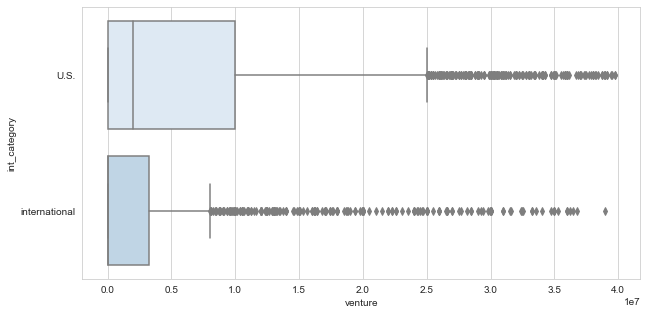

In [141]:
# international vs U.S. companies - venture funding
# U.S. companies recieve more funding

plt.figure(figsize=(10,5))
sns.boxplot(x=df_box['venture'], y=df_box['int_category'])
df_box['int_category'].value_counts()

Text(0.5, 1.0, 'Seed Funding')

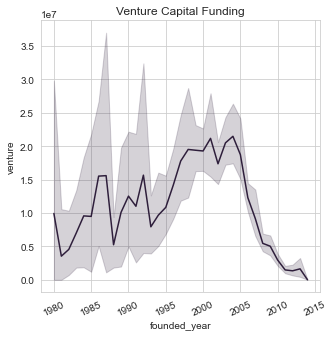

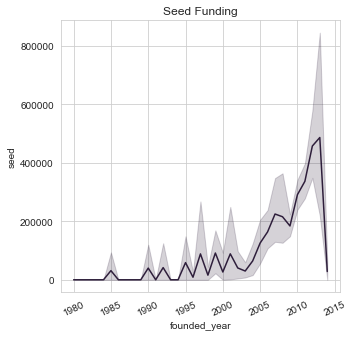

In [142]:
# drop off in 2014 may be due to lack of data
sns.set_palette('mako')

plt.figure(figsize=(5,5))
plt.title('Venture Capital Funding')
sns.lineplot(x = "founded_year", y = "venture", data = df)
plt.xticks(rotation = 25)

plt.figure(figsize=(5,5))
sns.lineplot(x = "founded_year", y = "seed", data = df)
plt.xticks(rotation = 25)
plt.title('Seed Funding')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'other'),
  Text(1, 0, 'Software'),
  Text(2, 0, 'Curated Web'),
  Text(3, 0, 'Mobile'),
  Text(4, 0, 'Enterprise Software'),
  Text(5, 0, 'Biotechnology'),
  Text(6, 0, 'Advertising'),
  Text(7, 0, 'Games'),
  Text(8, 0, 'E-Commerce'),
  Text(9, 0, 'Social Media'),
  Text(10, 0, 'Hardware + Software')])

<Figure size 720x720 with 0 Axes>

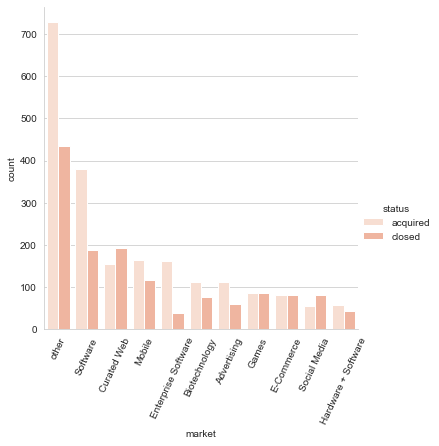

In [143]:
# top 10 markets by status

sns.set_palette('Reds')

df['market'].value_counts()[1:11]
top10_mkt = list(set(df['market'][df['market'].map(df['market'].value_counts()) >= 100]))
top10_mkt

plt.figure(figsize=(10,10))
sns.catplot(x='market',hue='status',data=df[df['market'].isin(top10_mkt)],
            kind="count", 
            order = df['market'][df['market'].isin(top10_mkt)].value_counts().index)
plt.xticks(rotation = 65)

SF Bay Area         1250
New York City        338
Boston               260
Los Angeles          186
London               146
Seattle              143
Washington, D.C.      85
Chicago               85
Austin                84
San Diego             77
Name: region, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'other'),
  Text(1, 0, 'SF Bay Area'),
  Text(2, 0, 'New York City'),
  Text(3, 0, 'Boston'),
  Text(4, 0, 'Los Angeles'),
  Text(5, 0, 'London'),
  Text(6, 0, 'Seattle'),
  Text(7, 0, 'Washington, D.C.'),
  Text(8, 0, 'Chicago'),
  Text(9, 0, 'Austin'),
  Text(10, 0, 'San Diego')])

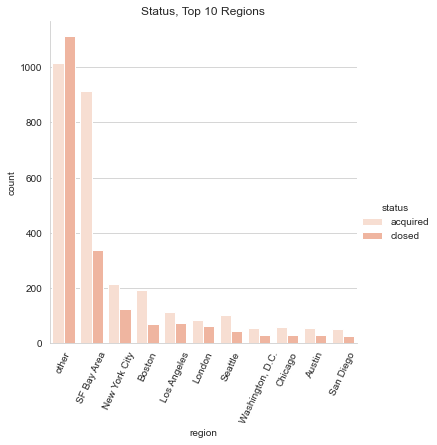

In [144]:
# top regions
print(df['region'].value_counts()[1:11])
top10_reg = list(set(df['region'][df['region'].map(df['region'].value_counts()) >= 77]))
top10_reg

sns.catplot(x='region',hue='status',data=df[df['region'].isin(top10_reg)],
            kind="count", 
            order = df['region'][df['region'].isin(top10_reg)].value_counts().index)
plt.title('Status, Top 10 Regions')
plt.xticks(rotation = 65)

In [145]:
#top_10_regions

piv = pd.pivot_table(df[['status', 'region']], index=['region'], columns=['status'], 
                     aggfunc=len, fill_value=0, 
                     margins=True).sort_values(by='All', ascending=False)

top_10_reg = piv[1:]

top_10_reg['failure_rate'] = top_10_reg['closed'] / top_10_reg['All']
top_10_reg = top_10_reg.sort_values(by='failure_rate', ascending=True).reset_index()

top_10_reg

status,region,acquired,closed,All,failure_rate
0,Boston,192,68,260,0.261538
1,SF Bay Area,914,336,1250,0.268800
2,Seattle,101,42,143,0.293706
3,San Diego,52,25,77,0.324675
4,Chicago,57,28,85,0.329412
5,"Washington, D.C.",56,29,85,0.341176
6,Austin,55,29,84,0.345238
7,New York City,214,124,338,0.366864
8,Denver,47,28,75,0.373333
9,Los Angeles,114,72,186,0.387097


[Text(0.5, 0, 'Region'),
 Text(0, 0.5, 'Failure Rate'),
 Text(0.5, 1.0, 'Failure Rate by Region')]

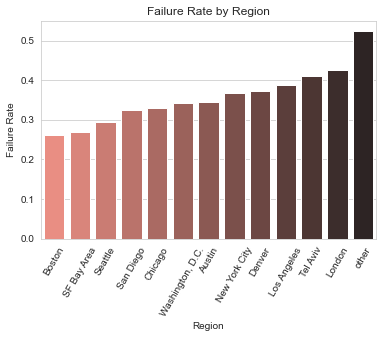

In [146]:
# failure rate by region
sns.set_style("whitegrid")
sns.set_palette('mako')

g = sns.barplot(x='region', y="failure_rate", data=top_10_reg, 
                palette="dark:salmon_r")
              
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(xlabel='Region', 
      ylabel='Failure Rate', 
      title='Failure Rate by Region')

<AxesSubplot:xlabel='venture', ylabel='status'>

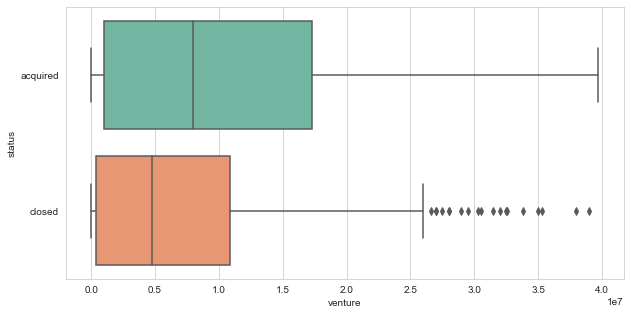

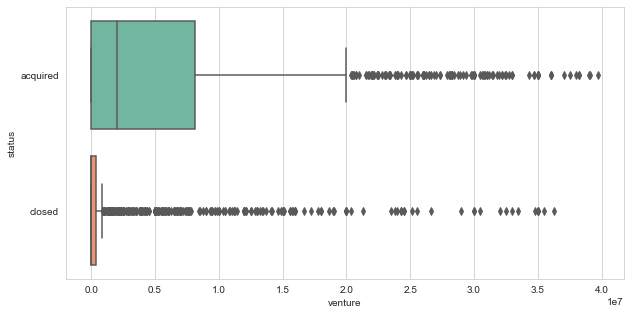

In [147]:
sns.set_palette('Set2')

plt.figure(figsize=(10,5))
sns.boxplot(x=df_box['venture'][df_box['founded_year'] < 2005], 
            y=df_box['status'][df_box['founded_year'] < 2005])

plt.figure(figsize=(10,5))
sns.boxplot(x=df_box['venture'][df_box['founded_year'] >= 2005], 
            y=df_box['status'][df_box['founded_year'] >= 2005])

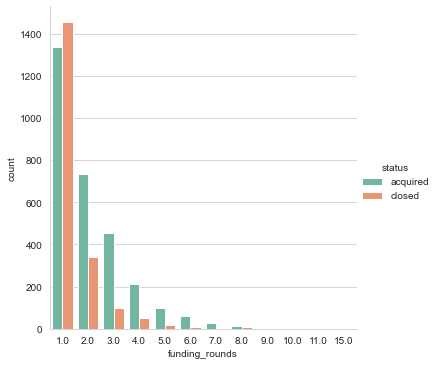

In [148]:
# number of funding rounds
df['funding_rounds'].value_counts()

# acquired or closed by number of funding rounds
sns.catplot(x='funding_rounds',hue='status', data=df, kind="count") 

,funding_rounds,count,sum,pct_fail
0,1.0,2793,1456,0.521303
1,2.0,1073,339,0.315937
2,3.0,552,100,0.181159
3,4.0,263,51,0.193916
4,5.0,118,20,0.169492
5,6.0,70,7,0.100000
6,7.0,32,5,0.156250
7,8.0,19,8,0.421053
8,9.0,5,0,0.000000
9,10.0,2,0,0.000000


[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5')]

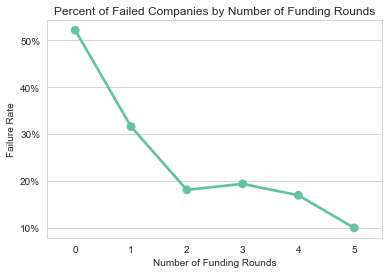

In [149]:
# failure rate by number of funding rounds
encoder = LabelEncoder()

df_fr = df[['funding_rounds', 'status']]
df_fr['cat'] = pd.Series(encoder.fit_transform(df['status'])) # encoding for status
df_fr_group = pd.DataFrame(df_fr[['funding_rounds', 'cat']].\
                           groupby('funding_rounds').agg(['count', 'sum']))
df_fr_group = df_fr_group.droplevel(axis=1, level=0).reset_index()
df_fr_group['pct_fail'] = df_fr_group['sum'] / df_fr_group['count']

display(df_fr_group) # too few companies per round beyond 6 rounds, will exclude in plot

# plot
sns.set_style("whitegrid")
sns.set_palette('Set2')
g = sns.pointplot(data=df_fr_group[:6], x="funding_rounds", y="pct_fail")
g.set(xlabel='Number of Funding Rounds', 
      ylabel='Failure Rate', 
      title='Percent of Failed Companies by Number of Funding Rounds')

vals = g.get_yticks()
g.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

vals = g.get_xticks()
g.set_xticklabels(['{:,.0f}'.format(x) for x in vals])

[Text(0.5, 0, 'Total Funding (USD), Percentile'),
 Text(0, 0.5, 'Company Count'),
 Text(0.5, 1.0, 'Status by Percentile of Total Funding')]

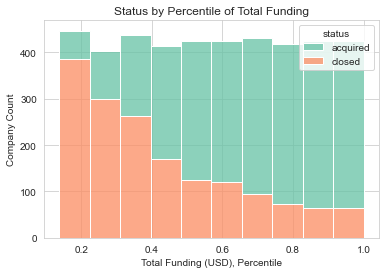

In [150]:
# funding percentile / status
# few companies in highest percentile of total funding

df['funding_pct'] = df.funding_total_usd.rank(pct=True)
g = sns.histplot(df[['funding_pct', 'status']][df['funding_total_usd']!=0], 
                 x='funding_pct', hue='status', bins=10, multiple='stack')

g.set(xlabel='Total Funding (USD), Percentile', 
      ylabel='Company Count', 
      title='Status by Percentile of Total Funding')

<AxesSubplot:xlabel='funding_pct', ylabel='Count'>

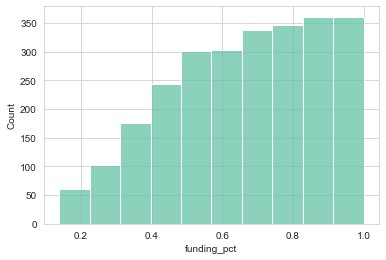

In [151]:
sns.histplot(df['funding_pct'][(df['status']=='acquired') & 
                               (df['funding_total_usd']!=0)], bins=10)

<AxesSubplot:xlabel='funding_pct', ylabel='Count'>

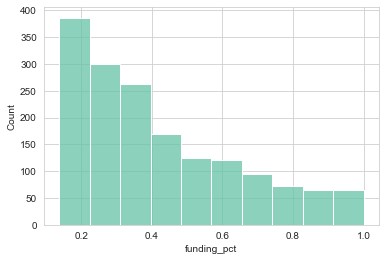

In [152]:
sns.histplot(df['funding_pct'][(df['status']=='closed') & 
                               (df['funding_total_usd']!=0)], bins=10)

In [153]:
df_fr.groupby('status').mean()

,funding_rounds,cat
status,,
acquired,2.125000,0
closed,1.449648,1


In [154]:
df_time = df[['status', 'time_to_first_funding']]
df_time.groupby('status').mean()

,time_to_first_funding
status,
acquired,3.740585
closed,1.685871


In [155]:
df_time2 = df[['status', 'time_first_to_last_funding']]
df_time2.groupby('status').mean()

,time_first_to_last_funding
status,
acquired,1.493806
closed,0.509975


In [156]:
df['age'] = df['time_to_first_funding'] + df['time_first_to_last_funding']

df_time3 = df[['status', 'age']]
df_time3.groupby('status').mean()

,age
status,
acquired,5.234391
closed,2.195846


In [157]:
# time / age by status
df_time3 = df[['status', 'time_to_first_funding','time_first_to_last_funding', 
               'age']]
df_time3.groupby('status').mean()

,time_to_first_funding,time_first_to_last_funding,age
status,,,
acquired,3.740585,1.493806,5.234391
closed,1.685871,0.509975,2.195846


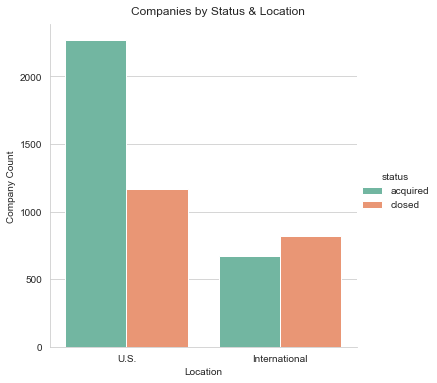

In [158]:
# companies by status & location
sns.set_style("whitegrid")
sns.set_palette('Set2')

g = sns.catplot(x='international',hue='status', data=df, kind="count") 
g.set_xticklabels(["U.S.", "International"])
g.set(xlabel='Location', ylabel='Company Count')
g.fig.suptitle("Companies by Status & Location", y=1.02);

<AxesSubplot:xlabel='one_funding_round', ylabel='count'>

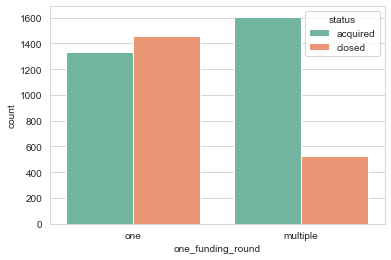

In [159]:
# status by whether a company has had one or multiple funding rounds
# success rate much higher for co's with more than one funding round

sns.countplot(x='one_funding_round',hue='status', data=df, orient='v') 

<AxesSubplot:xlabel='founded_year', ylabel='funding_total_usd'>

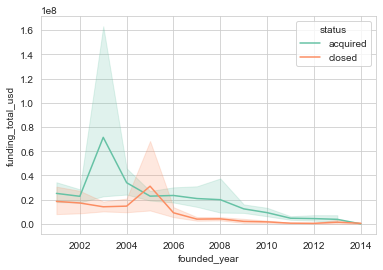

In [160]:
# can clearly see higher funding for acquired companies
# but drops off to 0 in 2014, likely due to lack of data in later yrs

sns.lineplot(x="founded_year", y="funding_total_usd", hue="status", 
             data=df[(df['funding_total_usd']>0) & 
                     (df['funding_total_usd']<0.5e13) & 
                     (df['founded_year']>2000)])

In [161]:
# funding per year
df_fund_time = df[(df['funding_total_usd']>0) & 
                  (df['funding_total_usd']<0.5e13) & 
                  (df['founded_year']>1998) & 
                  (df['status']=='closed')]

df_fund_time2 = df[(df['funding_total_usd']>0) & 
                  (df['funding_total_usd']<0.5e13) & 
                  (df['founded_year']>1998) & 
                  (df['status']=='acquired')]

## mean & median funding per yr
ft = df_fund_time[['venture', 'founded_year']].groupby('founded_year').agg(['mean', 'median', 'count'])
ft2 = df_fund_time2[['venture', 'founded_year']].groupby('founded_year').agg(['mean', 'median', 'count'])



df_ft_group = ft.droplevel(axis=1, level=0).reset_index()
df_ft_group2 = ft2.droplevel(axis=1, level=0).reset_index()

df_ft_group

,founded_year,mean,median,count
0,1999,1.544266e+07,9100000.0,32
1,2000,1.773795e+07,9857744.0,38
2,2001,1.745589e+07,4750000.0,22
3,2002,1.245949e+07,6500000.0,36
4,2003,1.380522e+07,9050000.0,56
5,2004,1.230243e+07,4950000.0,66
6,2005,2.016000e+07,5000000.0,97
7,2006,6.240685e+06,1000000.0,147
8,2007,3.476910e+06,0.0,191
9,2008,3.241054e+06,0.0,160


<AxesSubplot:xlabel='founded_year', ylabel='mean'>

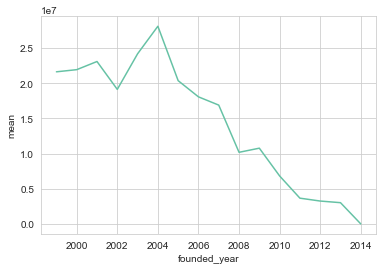

In [162]:
# funding over time
# again, potential lack of data in later years
sns.lineplot(x="founded_year", y="mean", data=df_ft_group2)

,founded_year,count,sum,pct_fail,acq
0,1980,5,1,0.200000,4
1,1981,5,0,0.000000,5
2,1982,7,0,0.000000,7
3,1983,16,2,0.125000,14
4,1984,13,1,0.076923,12
5,1985,16,2,0.125000,14
6,1986,11,1,0.090909,10
7,1987,9,1,0.111111,8
8,1988,11,1,0.090909,10
9,1989,15,4,0.266667,11


[Text(0, 0, '2000'),
 Text(1, 0, '2001'),
 Text(2, 0, '2002'),
 Text(3, 0, '2003'),
 Text(4, 0, '2004'),
 Text(5, 0, '2005'),
 Text(6, 0, '2006'),
 Text(7, 0, '2007'),
 Text(8, 0, '2008'),
 Text(9, 0, '2009'),
 Text(10, 0, '2010'),
 Text(11, 0, '2011'),
 Text(12, 0, '2012'),
 Text(13, 0, '2013'),
 Text(14, 0, '2014')]

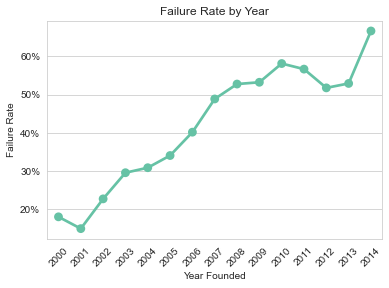

In [163]:
# failure rate by year
# fewer companies succeed in recent years

encoder = LabelEncoder()

df['cat'] = pd.Series(encoder.fit_transform(df['status'])) 

df_yr_group = pd.DataFrame(df[['founded_year', 'cat']].groupby('founded_year').agg(['count', 'sum']))

df_yr_group = df_yr_group.droplevel(axis=1, level=0).reset_index()
df_yr_group['pct_fail'] = df_yr_group['sum'] / df_yr_group['count']
df_yr_group['acq'] = df_yr_group['count'] - df_yr_group['sum']

display(df_yr_group)

g = sns.pointplot(data=df_yr_group[20:], x="founded_year", y="pct_fail")
g.set(xlabel='Year Founded', 
      ylabel='Failure Rate', 
      title='Failure Rate by Year')

vals = g.get_yticks()
g.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [164]:
# comb X_train, X_test, y_train, y_test

processed_data_X = pd.concat([X_train_processed, X_test_processed], axis=0)
processed_data_y = pd.concat([y_train, y_test], axis=0)
processed_data = pd.concat([processed_data_X.reset_index(drop=True), 
                            processed_data_y.reset_index(drop=True)], axis=1)
processed_data

,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_D,round_E,round_F,round_G,time_to_first_funding,time_first_to_last_funding,founded_month,founded_year,international,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.298630,0.000000,4,2009,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.498630,0.873973,1,2012,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.961644,0.000000,1,2007,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.942466,0.000000,1,2010,0,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3340000.0,0.0,0.0,0.0,3.498630,7.071233,1,2003,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.328767,0.000000,1,2008,0,1
4926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.295890,4.334247,1,2001,0,1
4927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.750685,0.000000,11,2011,0,1
4928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28.049315,0.000000,1,1983,0,0


In [165]:
#mkt_other = X_train_processed[X_train_processed['market_other']==1]
#mkt_clean_tech = X_train_processed[X_train_processed['market_Clean Technology']==1]

#mkt_other

#mkt_other['failure_rate'] = top_10_reg['closed'] / top_10_reg['All']
#top_10_reg = top_10_reg.sort_values(by='failure_rate', ascending=True).reset_index()

In [166]:
# further investigations needed:

# top 10 region by success rate

# top 10 region by failure rate

# top 10 market by success rate

# top 10 market by failure rate